In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
import hopsworks

# Login to the Hopsworks project using your API key
project = hopsworks.login(
    api_key_value="uVSWPn5SRhttOERh.NysMaEwnuCSaxzsMg3MJf9uzIuqM6Jwt8go5sR6hY1pG04ZrW8aM1BwmyywdIcQX")

# Get the feature store instance
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1043609
2024-09-24 14:57:47,833 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-09-24 14:57:47,833 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
feature_group_city_weather = fs.get_feature_group(
    name="city_weather_features", version=1)
feature_group_trucks = fs.get_feature_group(name="trucks_features", version=1)
feature_group_truck_schedule = fs.get_feature_group(
    name="trucks_schedule_features", version=1)
feature_group_routes_weather = fs.get_feature_group(
    name="routes_weather_features", version=1)
feature_group_routes = fs.get_feature_group(name="routes_features", version=1)
feature_group_traffic = fs.get_feature_group(
    name="traffic_features", version=1)
feature_group_drivers = fs.get_feature_group(
    name="drivers_features", version=1)

In [4]:
df_trucks = feature_group_trucks.read()
df_truck_schedule = feature_group_truck_schedule.read()
df_traffic = feature_group_traffic.read()
df_routes_weather = feature_group_routes_weather.read()
df_routes = feature_group_routes.read()
df_drivers = feature_group_drivers.read()
df_city_weather = feature_group_city_weather.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (13.41s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.53s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


In [5]:
df_trucks = df_trucks.drop(columns=['event_date', 'index'])
df_truck_schedule = df_truck_schedule.drop(columns=['event_date', 'index'])
df_traffic = df_traffic.drop(columns=['event_date', 'index'])
df_routes_weather = df_routes_weather.drop(columns=['event_date', 'index'])
df_routes = df_routes.drop(columns=['event_date', 'index'])
df_drivers = df_drivers.drop(columns=['event_date', 'index'])
df_city_weather = df_city_weather.drop(columns=['event_date', 'index'])

In [6]:
df_trucks.head(10)

,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type
0,91138034,13,15000.0,19,gas
1,24681381,11,15000.0,23,diesel
2,15165874,8,15000.0,23,diesel
3,54036321,10,15000.0,24,diesel
4,26079111,6,3000.0,26,diesel
5,12779172,10,3000.0,22,diesel
6,53279386,10,3000.0,18,gas
7,32241370,11,3000.0,20,diesel
8,22563087,8,6000.0,20,gas
9,21928760,13,6000.0,17,gas


In [7]:
df_trucks.shape

(1201, 5)

In [8]:
df_trucks.describe()

,truck_id,truck_age,load_capacity_pounds,mileage_mpg
count,1.201000e+03,1201.000000,1201.000000,1201.000000
mean,3.249928e+07,9.518734,8534.554538,20.837635
std,2.187359e+07,1.992032,5576.798364,3.692711
min,1.000839e+07,4.000000,3000.000000,11.000000
25%,1.814850e+07,8.000000,4000.000000,18.000000
50%,2.585326e+07,10.000000,6000.000000,21.000000
75%,3.339385e+07,11.000000,15000.000000,24.000000
max,9.998167e+07,15.000000,20000.000000,29.000000


In [9]:
correlation_matrix = df_trucks[['truck_age',
                                'load_capacity_pounds', 'mileage_mpg']].corr()

In [10]:
correlation_matrix

,truck_age,load_capacity_pounds,mileage_mpg
truck_age,1.000000,-0.038934,-0.033176
load_capacity_pounds,-0.038934,1.000000,0.014577
mileage_mpg,-0.033176,0.014577,1.000000


2024-09-24 14:59:15,309 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




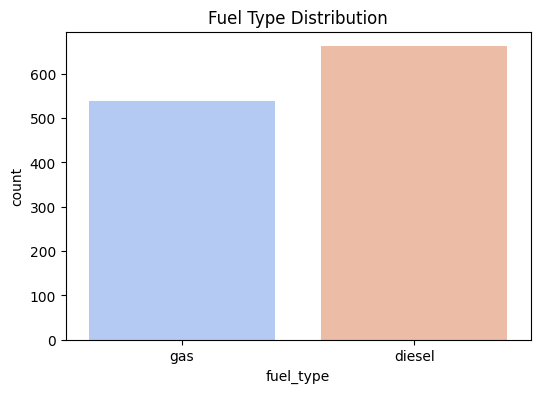

In [11]:
fuel_type_distribution = df_trucks['fuel_type'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='fuel_type', data=df_trucks, palette='coolwarm')
plt.title('Fuel Type Distribution')
plt.show()

Count of Each fuel type, Disel trucks are used more compared to that of gas


In [12]:
average_mileage = df_trucks.groupby('fuel_type')['mileage_mpg'].mean()

# Printing the result
for fuel, avg_mpg in average_mileage.items():
    print(f"Fuel Type: {fuel}, Average Mileage: {avg_mpg:.2f} mpg")

Fuel Type: diesel, Average Mileage: 23.60 mpg
Fuel Type: gas, Average Mileage: 17.44 mpg


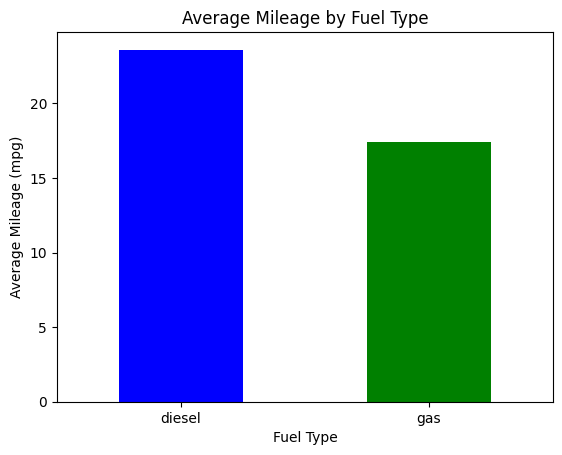

In [13]:
average_mileage.plot(kind='bar', color=['blue', 'green'])

# Adding labels and title
plt.title('Average Mileage by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Mileage (mpg)')
plt.xticks(rotation=0)

# Display the graph
plt.show()

Trucks using Disel has higher efficieny compared to the once using gas but both of them managed to give atleast 15mpg


In [14]:
def efficiency_category(mpg):
    if mpg > 20:
        return 'High Efficiency'
    elif 15 <= mpg <= 20:
        return 'Medium Efficiency'
    else:
        return 'Low Efficiency'


df_trucks['efficiency_category'] = df_trucks['mileage_mpg'].apply(
    efficiency_category)

In [15]:
df_trucks['efficiency_category'] = df_trucks['mileage_mpg'].apply(
    efficiency_category)

# Counting the low-efficiency vehicles with respect to fuel type
low_efficiency_counts = df_trucks[df_trucks['efficiency_category']
                                  == 'Low Efficiency'].groupby('fuel_type')['truck_id'].count()

# Printing the result
print(low_efficiency_counts)

fuel_type
gas    39
Name: truck_id, dtype: int64


All the low efficieny vehicles are those using gas rather than disel


2024-09-24 14:59:17,152 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




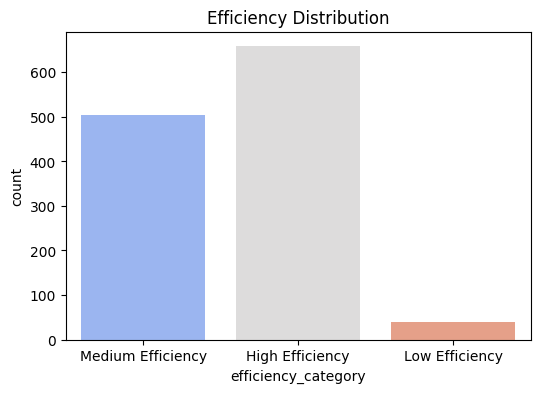

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='efficiency_category', data=df_trucks, palette='coolwarm')
plt.title('Efficiency Distribution')
plt.show()

In [17]:
merged_df_t_ts = pd.merge(df_trucks, df_truck_schedule,
                          on='truck_id', how='inner')

merged_df_t_ts.head()

,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type,efficiency_category,route_id,departure_date,estimated_arrival,delay
0,91138034,13,15000.0,19,gas,Medium Efficiency,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0
1,91138034,13,15000.0,19,gas,Medium Efficiency,R-1c78b5ee,2019-02-06 07:00:00,2019-02-07 03:10:48,1
2,91138034,13,15000.0,19,gas,Medium Efficiency,R-7a989fc7,2019-01-01 07:00:00,2019-01-02 06:46:48,0
3,91138034,13,15000.0,19,gas,Medium Efficiency,R-c8bee627,2019-01-31 07:00:00,2019-01-31 23:49:48,0
4,91138034,13,15000.0,19,gas,Medium Efficiency,R-94708871,2019-01-13 07:00:00,2019-01-13 18:48:00,0


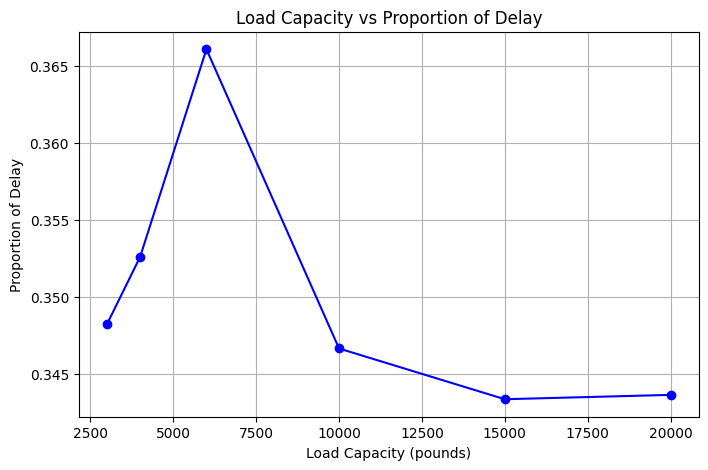

In [18]:
load_delay = merged_df_t_ts.groupby('load_capacity_pounds')['delay'].mean()


plt.figure(figsize=(8, 5))
plt.plot(load_delay.index, load_delay.values, marker='o', color='blue')
plt.title('Load Capacity vs Proportion of Delay')
plt.xlabel('Load Capacity (pounds)')
plt.ylabel('Proportion of Delay')
plt.grid(True)
plt.show()

2024-09-24 14:59:17,684 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




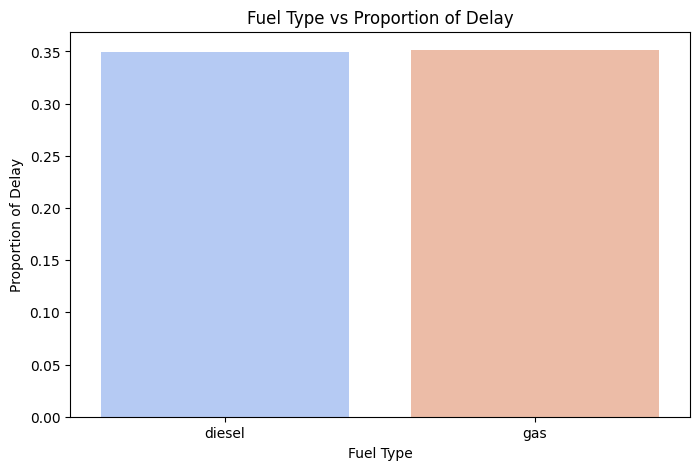

In [19]:
fuel_delay = merged_df_t_ts.groupby('fuel_type')['delay'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=fuel_delay.index, y=fuel_delay.values, palette='coolwarm')
plt.title('Fuel Type vs Proportion of Delay')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion of Delay')
plt.show()

Fuel Type does'nt infulence delay, either gas or disel but can infulence cost. According to our usecase of Delay prediction we can drop fuel type.


2024-09-24 14:59:18,045 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 14:59:18,048 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


2024-09-24 14:59:18,056 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


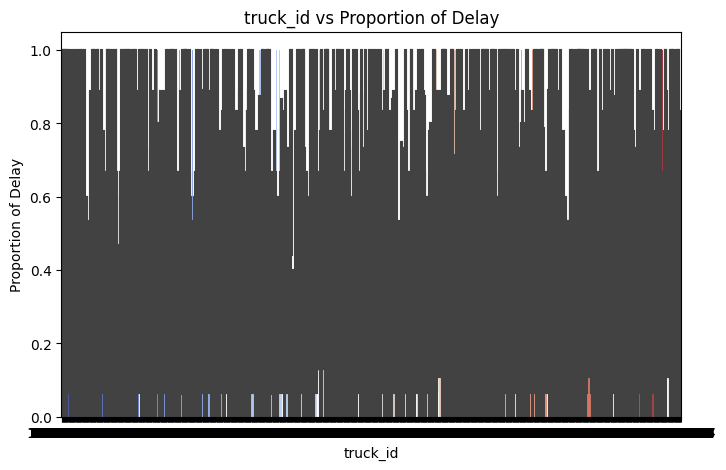

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x='truck_id', y='delay', palette='coolwarm', data=merged_df_t_ts)
plt.title('truck_id vs Proportion of Delay')
plt.xlabel('truck_id')
plt.ylabel('Proportion of Delay')
plt.show()

In [21]:
delay_counts = merged_df_t_ts.groupby(
    'route_id')['delay'].value_counts().unstack(fill_value=0)

# Separate routes with more delays than non-delays
more_delays = delay_counts[delay_counts[1] > delay_counts[0]].index.tolist()

# Separate routes with more non-delays than delays
more_non_delays = delay_counts[delay_counts[0]
                               > delay_counts[1]].index.tolist()

print("Routes with more delays than non-delays:", more_delays)
print("Routes with more non-delays than delays:", more_non_delays)

Routes with more delays than non-delays: ['R-006548e0', 'R-00778fdb', 'R-00a1afca', 'R-00b9095d', 'R-01084cac', 'R-012c2705', 'R-0149242c', 'R-019d66e4', 'R-02124ef5', 'R-0225d21a', 'R-023e7179', 'R-024b5adb', 'R-02923be8', 'R-0371bf56', 'R-03e478bb', 'R-0436e4bf', 'R-047a1143', 'R-04ad4880', 'R-058f99b5', 'R-05e2472d', 'R-05f9858a', 'R-0685acb5', 'R-06dfe39e', 'R-06f26f8a', 'R-07e0d11f', 'R-0810e90f', 'R-08617151', 'R-08d006da', 'R-08fd4a69', 'R-0ab8172b', 'R-0c8a29cd', 'R-0c8b648e', 'R-0cbb1381', 'R-0d0ed492', 'R-0d5b630e', 'R-0da912a2', 'R-0de7ba0d', 'R-0e4cf867', 'R-0f5d7085', 'R-0f705429', 'R-0fc1cc20', 'R-10bfb9fb', 'R-10ef4bac', 'R-11096a8f', 'R-112b790b', 'R-12cbe9eb', 'R-132d8754', 'R-138b949d', 'R-13bee5ff', 'R-141064f1', 'R-143555e9', 'R-15b5925d', 'R-16097e41', 'R-163b08b9', 'R-168b1777', 'R-1835b5ed', 'R-1868332a', 'R-187fd321', 'R-18965ef0', 'R-18bb1dc1', 'R-18f7717e', 'R-199223bb', 'R-1a32157c', 'R-1a802b07', 'R-1acdeb76', 'R-1b7d4b68', 'R-1b9ec3cf', 'R-1bcec3a6', 'R-1bd

The above analysis shows that, more that 50% of the routes have a significant delay but ofcourse it can be because of various factors like weather, traffic, etc


2024-09-24 14:59:27,823 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 14:59:27,824 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


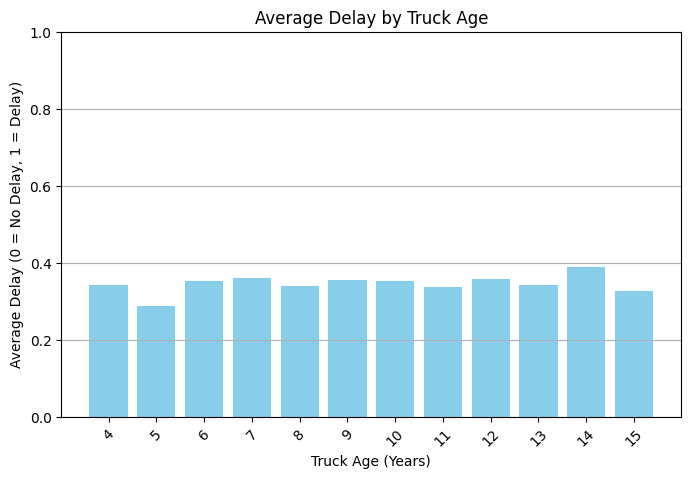

In [22]:
average_delay = merged_df_t_ts.groupby(
    'truck_age')['delay'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(average_delay['truck_age'].astype(str),
        average_delay['delay'], color='skyblue')
plt.xlabel('Truck Age (Years)')
plt.ylabel('Average Delay (0 = No Delay, 1 = Delay)')
plt.title('Average Delay by Truck Age')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

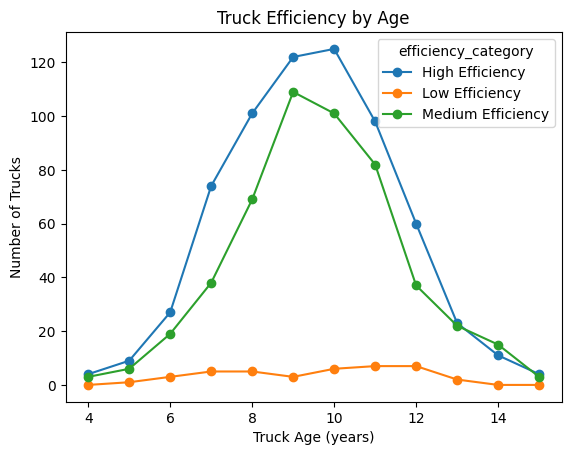

In [23]:
efficiency_by_age = df_trucks.groupby(
    ['truck_age', 'efficiency_category']).size().unstack(fill_value=0)

efficiency_by_age.plot(kind='line', marker='o')

plt.title('Truck Efficiency by Age')
plt.xlabel('Truck Age (years)')
plt.ylabel('Number of Trucks')
plt.xticks(rotation=0)

plt.show()

Trucks with all ages show all types of efficiencies but if we are concerned with cost cutting we can filter out the respective trucks and proceed but for our use case with delay there is equal infulence as shown in the above visualizations.


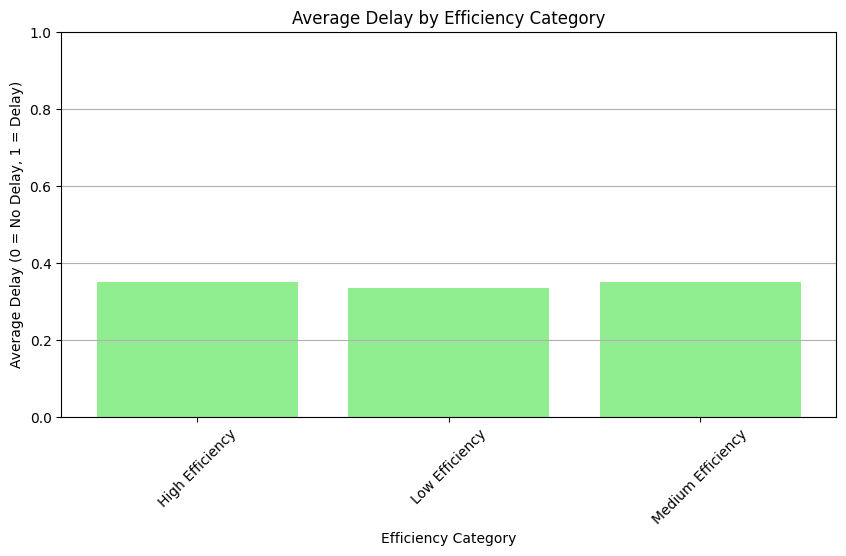

In [24]:
average_delay = merged_df_t_ts.groupby('efficiency_category')[
    'delay'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(average_delay['efficiency_category'],
        average_delay['delay'], color='lightgreen')
plt.xlabel('Efficiency Category')
plt.ylabel('Average Delay (0 = No Delay, 1 = Delay)')
plt.title('Average Delay by Efficiency Category')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Trucks of all ages have almost similar proportion of delay, so we can drop fuel type, Truck age, and efficieny - these all attributes can be helpful in cost reduction but not in predicting the delays


In [25]:
df_trucks = df_trucks.drop(
    columns=['mileage_mpg', 'efficiency_category', 'fuel_type', 'truck_age'], axis=1)

In [26]:
df_trucks

,truck_id,load_capacity_pounds
0,91138034,15000.0
1,24681381,15000.0
2,15165874,15000.0
3,54036321,15000.0
4,26079111,3000.0
...,...,...
1196,61984883,3000.0
1197,83616092,15000.0
1198,23236058,20000.0
1199,29596705,15000.0


In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
# label_encoder_fuel = LabelEncoder()
# label_encoder_efficiency = LabelEncoder()

# # Apply label encoding to 'fuel_type' and 'efficiency_category'
# df_trucks['fuel_type_encoded'] = label_encoder_fuel.fit_transform(
#     df_trucks['fuel_type'])
# df_trucks['efficiency_category_encoded'] = label_encoder_efficiency.fit_transform(
#     df_trucks['efficiency_category'])

# Drop original categorical columns and keep the encoded columns
# df_trucks_encoded = df_trucks.drop(
#     ['fuel_type', 'efficiency_category'], axis=1)

# # Display the encoded DataFrame
# print("\nLabel Encoded Trucks Data:")
# df_trucks_encoded

In [28]:
scalar_trucks = StandardScaler()
df_trucks[['load_capacity_pounds']] = scalar_trucks.fit_transform(
    df_trucks[['load_capacity_pounds']])

In [29]:
# from datetime import datetime
# df_trucks['event_date'] = datetime.today().strftime('%Y-%m-%d')

In [30]:
df_trucks_transformed = df_trucks

In [31]:
df_trucks_transformed

,truck_id,load_capacity_pounds
0,91138034,1.159830
1,24681381,1.159830
2,15165874,1.159830
3,54036321,1.159830
4,26079111,-0.992838
...,...,...
1196,61984883,-0.992838
1197,83616092,1.159830
1198,23236058,2.056775
1199,29596705,1.159830


In [32]:
df_trucks_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   truck_id              1201 non-null   int64  
 1   load_capacity_pounds  1201 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 18.9 KB


Truck Schedule Analysis


In [33]:
df_truck_schedule

,truck_id,route_id,departure_date,estimated_arrival,delay
0,25366317,R-6cf6fe85,2019-01-01 07:00:00,2019-01-01 21:48:00,0
1,16654459,R-0d5b630e,2019-01-28 07:00:00,2019-01-29 00:17:23,1
2,19095731,R-a2a4a0a7,2019-01-26 07:00:00,2019-01-27 12:36:00,0
3,22126955,R-b64f0229,2019-02-12 07:00:00,2019-02-13 01:04:48,0
4,21097795,R-6b4a42e2,2019-02-02 07:00:00,2019-02-04 05:28:48,0
...,...,...,...,...,...
12303,16654459,R-357c2068,2019-01-04 07:00:00,2019-01-04 20:09:00,0
12304,22171671,R-82abd9ca,2019-02-12 07:00:00,2019-02-12 14:24:00,0
12305,17591502,R-c40e40a1,2019-01-09 07:00:00,2019-01-13 04:52:48,1
12306,15000219,R-44465e11,2019-01-25 07:00:00,2019-01-25 15:20:24,0


In [34]:
df_truck_schedule['estimated_arrival'] = pd.to_datetime(
    df_truck_schedule['estimated_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')

In [35]:
df_truck_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12308 entries, 0 to 12307
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   truck_id           12308 non-null  int64 
 1   route_id           12308 non-null  object
 2   departure_date     12308 non-null  object
 3   estimated_arrival  12308 non-null  object
 4   delay              12308 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 480.9+ KB


In [36]:
df_truck_schedule['departure_date'] = pd.to_datetime(
    df_truck_schedule['departure_date']).dt.strftime('%Y-%m-%d %H:%M:%S')

In [37]:
df_truck_schedule

,truck_id,route_id,departure_date,estimated_arrival,delay
0,25366317,R-6cf6fe85,2019-01-01 07:00:00,2019-01-01 21:48:00,0
1,16654459,R-0d5b630e,2019-01-28 07:00:00,2019-01-29 00:17:23,1
2,19095731,R-a2a4a0a7,2019-01-26 07:00:00,2019-01-27 12:36:00,0
3,22126955,R-b64f0229,2019-02-12 07:00:00,2019-02-13 01:04:48,0
4,21097795,R-6b4a42e2,2019-02-02 07:00:00,2019-02-04 05:28:48,0
...,...,...,...,...,...
12303,16654459,R-357c2068,2019-01-04 07:00:00,2019-01-04 20:09:00,0
12304,22171671,R-82abd9ca,2019-02-12 07:00:00,2019-02-12 14:24:00,0
12305,17591502,R-c40e40a1,2019-01-09 07:00:00,2019-01-13 04:52:48,1
12306,15000219,R-44465e11,2019-01-25 07:00:00,2019-01-25 15:20:24,0


In [38]:
# df_truck_schedule['event_date'] = datetime.today().strftime('%Y-%m-%d')
df_truck_schedule_transformed = df_truck_schedule
df_truck_schedule_transformed

,truck_id,route_id,departure_date,estimated_arrival,delay
0,25366317,R-6cf6fe85,2019-01-01 07:00:00,2019-01-01 21:48:00,0
1,16654459,R-0d5b630e,2019-01-28 07:00:00,2019-01-29 00:17:23,1
2,19095731,R-a2a4a0a7,2019-01-26 07:00:00,2019-01-27 12:36:00,0
3,22126955,R-b64f0229,2019-02-12 07:00:00,2019-02-13 01:04:48,0
4,21097795,R-6b4a42e2,2019-02-02 07:00:00,2019-02-04 05:28:48,0
...,...,...,...,...,...
12303,16654459,R-357c2068,2019-01-04 07:00:00,2019-01-04 20:09:00,0
12304,22171671,R-82abd9ca,2019-02-12 07:00:00,2019-02-12 14:24:00,0
12305,17591502,R-c40e40a1,2019-01-09 07:00:00,2019-01-13 04:52:48,1
12306,15000219,R-44465e11,2019-01-25 07:00:00,2019-01-25 15:20:24,0


Trucks with higher delays:
      truck_id  delay
0     10008392      4
1     10042923      7
2     10048865      6
3     10056827      1
4     10140178      2
...        ...    ...
1244  99047862      7
1245  99485464      2
1246  99568033      5
1247  99664405      3
1248  99981667      4

[1184 rows x 2 columns]

Trucks with lower delays:
      truck_id  delay
31    10750770      0
46    11095479      0
58    11362115      0
62    11486762      0
81    11968468      0
...        ...    ...
1073  61002733      0
1090  64799581      0
1218  93764998      0
1220  94412953      0
1222  94792980      0

[65 rows x 2 columns]
2024-09-24 14:59:28,636 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 14:59:28,638 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be p

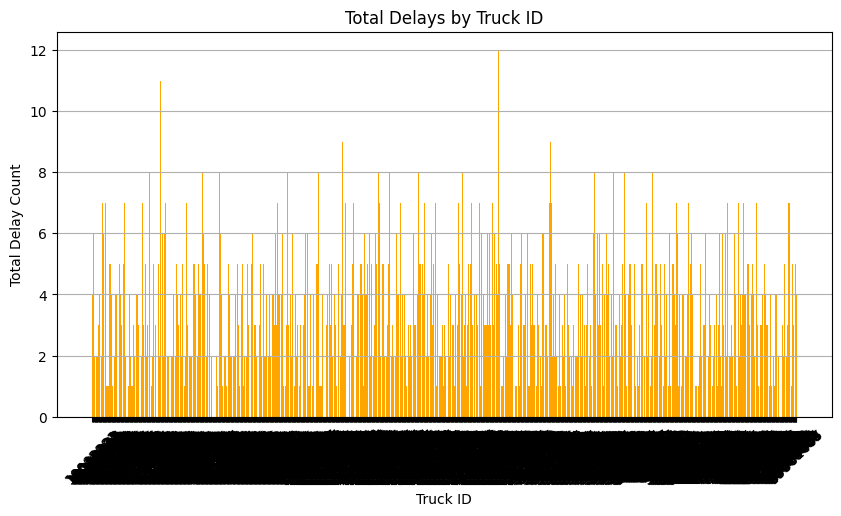

In [39]:
delay_counts = df_truck_schedule.groupby(
    'truck_id')['delay'].sum().reset_index()

# Separate trucks with higher delays and lower delays
# Assuming a threshold for higher delays (e.g., > 0)
threshold = 0
higher_delays = delay_counts[delay_counts['delay'] > threshold]
lower_delays = delay_counts[delay_counts['delay'] <= threshold]

# Print results
print("Trucks with higher delays:")
print(higher_delays)

print("\nTrucks with lower delays:")
print(lower_delays)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(delay_counts['truck_id'].astype(str),
        delay_counts['delay'], color='orange')
plt.xlabel('Truck ID')
plt.ylabel('Total Delay Count')
plt.title('Total Delays by Truck ID')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

The above analysis shows the truck id's and their respective number of time that had delays, and i have also printed the trucks that did'nt even have a single delay.


In [40]:
merged_df_t_ts_transformed = pd.merge(
    df_trucks_transformed, df_truck_schedule_transformed, on='truck_id', how='inner')
merged_df_t_ts_transformed = merged_df_t_ts_transformed.drop_duplicates()
merged_df_t_ts_transformed

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay
0,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0
1,91138034,1.159830,R-1c78b5ee,2019-02-06 07:00:00,2019-02-07 03:10:48,1
2,91138034,1.159830,R-7a989fc7,2019-01-01 07:00:00,2019-01-02 06:46:48,0
3,91138034,1.159830,R-c8bee627,2019-01-31 07:00:00,2019-01-31 23:49:48,0
4,91138034,1.159830,R-94708871,2019-01-13 07:00:00,2019-01-13 18:48:00,0
...,...,...,...,...,...,...
11278,29596705,1.159830,R-0371bf56,2019-01-06 07:00:00,2019-01-07 07:40:12,1
11279,29596705,1.159830,R-1835b5ed,2019-01-16 07:00:00,2019-01-17 08:39:36,1
11280,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1
11281,19336784,-0.992838,R-2e9a8868,2019-01-01 07:00:00,2019-01-06 13:15:00,0


In [41]:
merged_df_t_ts_transformed.isnull().sum()

truck_id                0
load_capacity_pounds    0
route_id                0
departure_date          0
estimated_arrival       0
delay                   0
dtype: int64

In [42]:
merged_df_t_ts_transformed = merged_df_t_ts_transformed.drop_duplicates()
merged_df_t_ts_transformed

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay
0,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0
1,91138034,1.159830,R-1c78b5ee,2019-02-06 07:00:00,2019-02-07 03:10:48,1
2,91138034,1.159830,R-7a989fc7,2019-01-01 07:00:00,2019-01-02 06:46:48,0
3,91138034,1.159830,R-c8bee627,2019-01-31 07:00:00,2019-01-31 23:49:48,0
4,91138034,1.159830,R-94708871,2019-01-13 07:00:00,2019-01-13 18:48:00,0
...,...,...,...,...,...,...
11278,29596705,1.159830,R-0371bf56,2019-01-06 07:00:00,2019-01-07 07:40:12,1
11279,29596705,1.159830,R-1835b5ed,2019-01-16 07:00:00,2019-01-17 08:39:36,1
11280,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1
11281,19336784,-0.992838,R-2e9a8868,2019-01-01 07:00:00,2019-01-06 13:15:00,0


In [43]:
mode_value = merged_df_t_ts_transformed['load_capacity_pounds'].mode()[0]
merged_df_t_ts_transformed['load_capacity_pounds'] = merged_df_t_ts_transformed['load_capacity_pounds'].fillna(
    mode_value)
merged_df_t_ts_transformed

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay
0,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0
1,91138034,1.159830,R-1c78b5ee,2019-02-06 07:00:00,2019-02-07 03:10:48,1
2,91138034,1.159830,R-7a989fc7,2019-01-01 07:00:00,2019-01-02 06:46:48,0
3,91138034,1.159830,R-c8bee627,2019-01-31 07:00:00,2019-01-31 23:49:48,0
4,91138034,1.159830,R-94708871,2019-01-13 07:00:00,2019-01-13 18:48:00,0
...,...,...,...,...,...,...
11278,29596705,1.159830,R-0371bf56,2019-01-06 07:00:00,2019-01-07 07:40:12,1
11279,29596705,1.159830,R-1835b5ed,2019-01-16 07:00:00,2019-01-17 08:39:36,1
11280,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1
11281,19336784,-0.992838,R-2e9a8868,2019-01-01 07:00:00,2019-01-06 13:15:00,0


# TRUCK AND TRUCK SCHEDULE


df_traffic Analysis


In [44]:
df_traffic

,route_id,no_of_vehicles,accident,datetime
0,R-4016d8c0,520.0,0,2019-01-11 05:00:00+00:00
1,R-3fc6b536,2352.0,0,2019-02-14 11:00:00+00:00
2,R-b5bc1ed4,2511.0,0,2019-01-22 07:00:00+00:00
3,R-eaef7c11,1902.0,0,2019-01-07 10:00:00+00:00
4,R-5941a689,504.0,0,2019-02-01 04:00:00+00:00
...,...,...,...,...
2459677,R-7acb8ef3,1975.0,0,2019-01-26 10:00:00+00:00
2459678,R-e8a0f522,2148.0,0,2019-01-21 07:00:00+00:00
2459679,R-fd69a297,2206.0,0,2019-01-15 15:00:00+00:00
2459680,R-68ecb793,708.0,0,2019-01-22 01:00:00+00:00


In [45]:
# df_traffic['date'] = pd.to_datetime(df_traffic['date'])
# df_traffic['hour'] = df_traffic['hour'].apply(
#     lambda x: f"{x // 100:02}:{x % 100:02}:00")
# df_traffic['datetime'] = pd.to_datetime(
#     df_traffic['date'].astype(str) + ' ' + df_traffic['hour'])
# df_traffic = df_traffic.drop(columns=['date', 'hour'])

In [46]:
df_traffic

,route_id,no_of_vehicles,accident,datetime
0,R-4016d8c0,520.0,0,2019-01-11 05:00:00+00:00
1,R-3fc6b536,2352.0,0,2019-02-14 11:00:00+00:00
2,R-b5bc1ed4,2511.0,0,2019-01-22 07:00:00+00:00
3,R-eaef7c11,1902.0,0,2019-01-07 10:00:00+00:00
4,R-5941a689,504.0,0,2019-02-01 04:00:00+00:00
...,...,...,...,...
2459677,R-7acb8ef3,1975.0,0,2019-01-26 10:00:00+00:00
2459678,R-e8a0f522,2148.0,0,2019-01-21 07:00:00+00:00
2459679,R-fd69a297,2206.0,0,2019-01-15 15:00:00+00:00
2459680,R-68ecb793,708.0,0,2019-01-22 01:00:00+00:00


In [47]:
# low_threshold = df_traffic['no_of_vehicles'].quantile(0.33)   # Bottom 33%
# medium_threshold = df_traffic['no_of_vehicles'].quantile(
#     0.66)  # 33rd to 66th percentile

# # Function to classify traffic based on thresholds


# def classify_traffic(no_of_vehicles):
#     if no_of_vehicles <= low_threshold:
#         return 'Low'
#     elif no_of_vehicles <= medium_threshold:
#         return 'Medium'
#     else:
#         return 'High'


# # Apply the classification to each row
# df_traffic['traffic_class'] = df_traffic['no_of_vehicles'].apply(
#     classify_traffic)

# df_traffic = df_traffic.drop(columns=['no_of_vehicles'])

intially i tried to categorize traffic but it showed the inflence on delay. so i wish to get the traffic in between the departure and estimated , as traffic changes hourly my intension is to get average traffic throughout the journey time and then categorize it


In [48]:
df_traffic

,route_id,no_of_vehicles,accident,datetime
0,R-4016d8c0,520.0,0,2019-01-11 05:00:00+00:00
1,R-3fc6b536,2352.0,0,2019-02-14 11:00:00+00:00
2,R-b5bc1ed4,2511.0,0,2019-01-22 07:00:00+00:00
3,R-eaef7c11,1902.0,0,2019-01-07 10:00:00+00:00
4,R-5941a689,504.0,0,2019-02-01 04:00:00+00:00
...,...,...,...,...
2459677,R-7acb8ef3,1975.0,0,2019-01-26 10:00:00+00:00
2459678,R-e8a0f522,2148.0,0,2019-01-21 07:00:00+00:00
2459679,R-fd69a297,2206.0,0,2019-01-15 15:00:00+00:00
2459680,R-68ecb793,708.0,0,2019-01-22 01:00:00+00:00


In [49]:
from datetime import datetime
df_traffic['datetime'] = df_traffic['datetime'].astype(str)

# Now you can use the .str accessor
df_traffic['datetime'] = df_traffic['datetime'].str.split('+').str[0]

# Optionally convert back to datetime
df_traffic['datetime'] = pd.to_datetime(df_traffic['datetime'])

In [50]:
df_traffic

,route_id,no_of_vehicles,accident,datetime
0,R-4016d8c0,520.0,0,2019-01-11 05:00:00
1,R-3fc6b536,2352.0,0,2019-02-14 11:00:00
2,R-b5bc1ed4,2511.0,0,2019-01-22 07:00:00
3,R-eaef7c11,1902.0,0,2019-01-07 10:00:00
4,R-5941a689,504.0,0,2019-02-01 04:00:00
...,...,...,...,...
2459677,R-7acb8ef3,1975.0,0,2019-01-26 10:00:00
2459678,R-e8a0f522,2148.0,0,2019-01-21 07:00:00
2459679,R-fd69a297,2206.0,0,2019-01-15 15:00:00
2459680,R-68ecb793,708.0,0,2019-01-22 01:00:00


In [51]:
merged_df_tr_ts = pd.merge(merged_df_t_ts_transformed,
                           df_traffic, how='inner', on='route_id')
# merged_df_tr_ts = merged_df_tr_ts.drop(columns=['event_date','index'])
merged_df_tr_ts

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,datetime
0,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,712.0,0,2019-02-04 05:00:00
1,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,246.0,0,2019-02-11 01:00:00
2,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2532.0,0,2019-01-06 22:00:00
3,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,478.0,0,2019-01-03 01:00:00
4,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,612.0,0,2019-01-23 06:00:00
...,...,...,...,...,...,...,...,...,...
11795123,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-15 14:00:00
11795124,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,144.0,0,2019-02-02 22:00:00
11795125,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2475.0,0,2019-02-14 08:00:00
11795126,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1906.0,0,2019-02-07 14:00:00


In [52]:
merged_df_tr_ts['departure_date'] = pd.to_datetime(
    merged_df_tr_ts['departure_date'])
merged_df_tr_ts['estimated_arrival'] = pd.to_datetime(
    merged_df_tr_ts['estimated_arrival'])
merged_df_tr_ts['datetime'] = pd.to_datetime(merged_df_tr_ts['datetime'])

# Filter the DataFrame
merged_df_tr_ts = merged_df_tr_ts[(merged_df_tr_ts['datetime'] > merged_df_tr_ts['departure_date']) & (
    merged_df_tr_ts['datetime'] < merged_df_tr_ts['estimated_arrival'])]
merged_df_tr_ts

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,datetime
9,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00
285,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 08:00:00
300,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 09:00:00
477,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 10:00:00
879,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 11:00:00
...,...,...,...,...,...,...,...,...,...
11795081,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2137.0,0,2019-01-16 11:00:00
11795087,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2338.0,0,2019-01-18 08:00:00
11795103,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1638.0,0,2019-01-15 15:00:00
11795114,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2110.0,0,2019-01-19 15:00:00


In [53]:
merged_df_tr_ts.isnull().any()

truck_id                False
load_capacity_pounds    False
route_id                False
departure_date          False
estimated_arrival       False
delay                   False
no_of_vehicles          False
accident                False
datetime                False
dtype: bool

In [54]:
merged_df_tr_ts = merged_df_tr_ts.drop_duplicates()
merged_df_tr_ts

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,datetime
9,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00
285,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 08:00:00
300,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 09:00:00
477,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 10:00:00
879,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 11:00:00
...,...,...,...,...,...,...,...,...,...
11795081,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2137.0,0,2019-01-16 11:00:00
11795087,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2338.0,0,2019-01-18 08:00:00
11795103,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1638.0,0,2019-01-15 15:00:00
11795114,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2110.0,0,2019-01-19 15:00:00


In [55]:
merged_df_tr_ts.isnull().sum()

truck_id                0
load_capacity_pounds    0
route_id                0
departure_date          0
estimated_arrival       0
delay                   0
no_of_vehicles          0
accident                0
datetime                0
dtype: int64

Since i have the traffic between the traffic time and i dont need the datetime column since it only dupplicates the dataset so i can drop off datetime


In [56]:
merged_df_tr_ts = merged_df_tr_ts.drop(columns=['datetime'])
merged_df_tr_ts = merged_df_tr_ts.drop_duplicates()
merged_df_tr_ts

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident
9,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0
285,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0
300,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0
477,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0
879,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0
...,...,...,...,...,...,...,...,...
11795081,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2137.0,0
11795087,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2338.0,0
11795103,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1638.0,0
11795114,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2110.0,0


2024-09-24 14:59:40,851 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 14:59:40,930 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


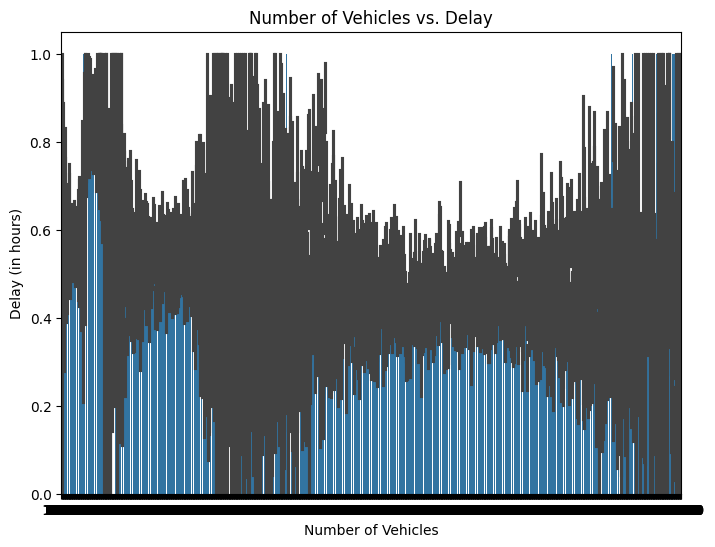

In [57]:
plt.figure(figsize=(8, 6))
sns.barplot(x='no_of_vehicles', y='delay', data=merged_df_tr_ts)
plt.title('Number of Vehicles vs. Delay')
plt.xlabel('Number of Vehicles')
plt.ylabel('Delay (in hours)')
plt.show()

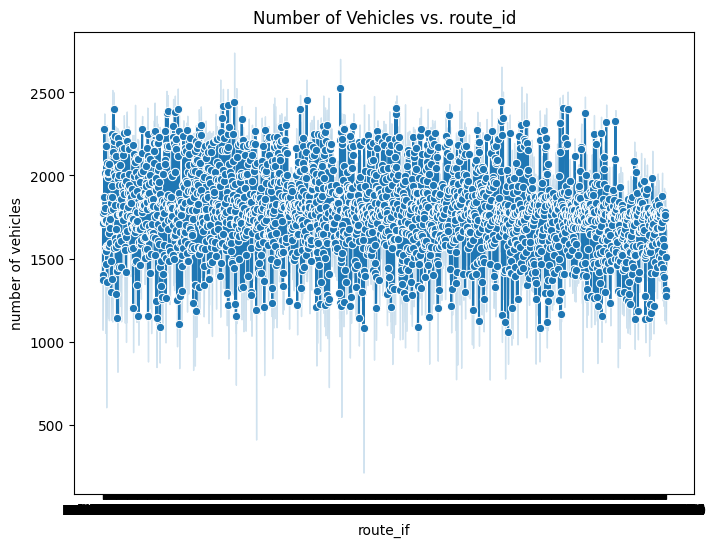

In [58]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='route_id', y='no_of_vehicles',
             data=merged_df_tr_ts, marker="o")
plt.title('Number of Vehicles vs. route_id')
plt.xlabel('route_if')
plt.ylabel('number of vehicles')
plt.show()

In [59]:
# threshold = merged_df_tr_ts['no_of_vehicles'].quantile(0.75)  # Top 25% of traffic considered as high traffic

# # Filter data where number of vehicles exceeds the threshold
# high_traffic_df = merged_df_tr_ts[merged_df_tr_ts['no_of_vehicles'] > threshold]

# # Print the high traffic times and details
# print("High Traffic Periods:")
# high_traffic_df[['datetime', 'no_of_vehicles', 'route_id']]

We need the date time and no_of_vehicles to indicate the traffic which is influencing the delay if the above times fall between departure and estimated arrival time


In [60]:
# le_traffic = LabelEncoder()
# merged_df_tr_ts['traffic_class'] = le_traffic.fit_transform(
#     merged_df_tr_ts['traffic_class'])

In [61]:
merged_df_tr_ts_transformed = merged_df_tr_ts
# merged_df_tr_ts_transformed['event_date'] = datetime.today().strftime('%Y-%m-%d')
# merged_df_tr_ts_transformed['traffic_time'] = merged_df_tr_ts_transformed['datetime']
# merged_df_tr_ts_transformed = merged_df_tr_ts_transformed.drop(columns='datetime')
merged_df_tr_ts_transformed = merged_df_tr_ts_transformed.drop_duplicates()
merged_df_tr_ts_transformed

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident
9,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0
285,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0
300,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0
477,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0
879,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0
...,...,...,...,...,...,...,...,...
11795081,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2137.0,0
11795087,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2338.0,0
11795103,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1638.0,0
11795114,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2110.0,0


In [62]:
merged_df_tr_ts_transformed = merged_df_tr_ts_transformed.drop_duplicates()
merged_df_tr_ts_transformed

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident
9,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0
285,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0
300,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0
477,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0
879,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0
...,...,...,...,...,...,...,...,...
11795081,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2137.0,0
11795087,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2338.0,0
11795103,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,1638.0,0
11795114,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,2110.0,0


In [63]:
merged_df_tr_ts_transformed.isnull().any()

truck_id                False
load_capacity_pounds    False
route_id                False
departure_date          False
estimated_arrival       False
delay                   False
no_of_vehicles          False
accident                False
dtype: bool

Only Filtered the traffic time between departure and estimated arrival time.

# MERGED TRAFFIC, TRUCKS AND TRUCK_SCHEDULE


df_routes_weather Analysis


In [64]:
df_routes_weather

,route_id,date,temp,wind_speed,description,humidity,pressure
0,R-6cc04ba7,2019-01-09 12:00:00,46,8,Overcast,98,1007
1,R-eed36b2e,2019-02-04 18:00:00,72,7,Clear,30,1012
2,R-6697852f,2019-02-13 18:00:00,63,7,Clear,85,1014
3,R-ac311c44,2019-01-26 12:00:00,68,6,Partly cloudy,63,1020
4,R-aa8616b8,2019-01-14 18:00:00,77,2,Moderate or heavy rain shower,81,1014
...,...,...,...,...,...,...,...
396144,R-abbcdcd3,2019-01-19 18:00:00,59,15,Sunny,57,1013
396145,R-9a984f09,2019-02-06 06:00:00,39,4,Moderate rain,93,1012
396146,R-47c6c141,2019-01-08 00:00:00,48,6,Patchy rain possible,95,1004
396147,R-b19ce159,2019-01-18 12:00:00,81,12,Sunny,16,1013


In [65]:
merged_df_tr_ts_transformed['departure_date'] = pd.to_datetime(
    merged_df_tr_ts_transformed['departure_date'])
merged_df_tr_ts_transformed['estimated_arrival'] = pd.to_datetime(
    merged_df_tr_ts_transformed['estimated_arrival'])
df_routes_weather['date'] = pd.to_datetime(df_routes_weather['date'])

In [66]:
merged_df_rw_tr_ts_t = pd.merge(
    merged_df_tr_ts_transformed, df_routes_weather, how='inner', on='route_id')

# Filter the merged data where the weather 'Date' is between 'departure_date' and 'estimated_arrival'
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t[(merged_df_rw_tr_ts_t['date'] >= merged_df_rw_tr_ts_t['departure_date']) & (
    merged_df_rw_tr_ts_t['date'] <= merged_df_rw_tr_ts_t['estimated_arrival'])]

In [67]:
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,date,temp,wind_speed,description,humidity,pressure
73,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
248,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
423,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
598,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
773,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42138769,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-18 12:00:00,86,7,Clear,52,1010
42138770,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-20 12:00:00,79,11,Clear,70,1011
42138773,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 06:00:00,0,2,Patchy light snow,98,1025
42138782,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 00:00:00,0,2,Patchy light snow,97,1025


In [68]:
# merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop(columns=['event_date_x','index','Date','temp','wind_speed','humidity','pressure','event_date_y'])
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop_duplicates()
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,date,temp,wind_speed,description,humidity,pressure
73,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
248,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
423,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
598,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
773,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42138769,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-18 12:00:00,86,7,Clear,52,1010
42138770,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-20 12:00:00,79,11,Clear,70,1011
42138773,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 06:00:00,0,2,Patchy light snow,98,1025
42138782,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 00:00:00,0,2,Patchy light snow,97,1025


In [69]:
merged_df_rw_tr_ts_t.isnull().sum()

truck_id                0
load_capacity_pounds    0
route_id                0
departure_date          0
estimated_arrival       0
delay                   0
no_of_vehicles          0
accident                0
date                    0
temp                    0
wind_speed              0
description             0
humidity                0
pressure                0
dtype: int64

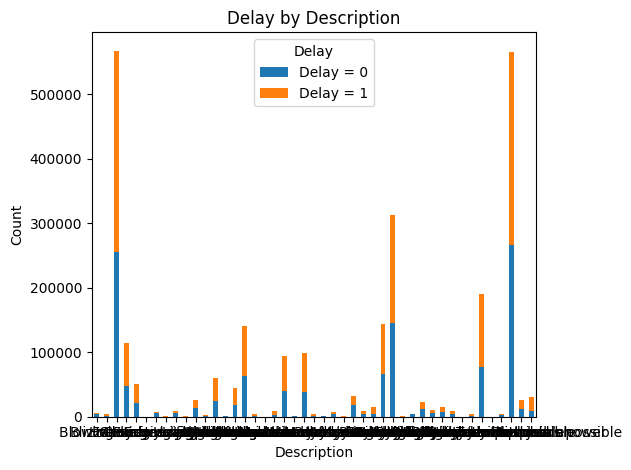

In [70]:
summary = merged_df_rw_tr_ts_t.groupby(
    ['description', 'delay']).size().unstack(fill_value=0)

# Plotting
summary.plot(kind='bar', stacked=True)
plt.title('Delay by Description')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Delay', labels=['Delay = 0', 'Delay = 1'])
plt.tight_layout()
plt.show()

In [71]:
summary = merged_df_rw_tr_ts_t.groupby(
    ['description', 'delay']).size().unstack(fill_value=0)

# Calculate total counts per description
summary['Total'] = summary.sum(axis=1)

# Calculate percentages
percentage = summary.div(summary['Total'], axis=0) * 100

# Display percentages
# Remove total column for clarity
percentage = percentage.drop(columns='Total')
print(percentage)

delay                                         0           1
description                                                
Blizzard                              71.550111   28.449889
Blowing snow                          44.778717   55.221283
Clear                                 44.885705   55.114295
Cloudy                                42.120776   57.879224
Fog                                   40.376195   59.623805
Freezing drizzle                       0.000000  100.000000
Freezing fog                          71.579549   28.420451
Heavy freezing drizzle                24.449183   75.550817
Heavy rain                            68.938231   31.061769
Heavy rain at times                   11.216931   88.783069
Heavy snow                            53.071158   46.928842
Ice pellets                           63.942308   36.057692
Light drizzle                         41.554680   58.445320
Light freezing rain                   75.529412   24.470588
Light rain                            39

In [72]:
percentage

delay,0,1
description,,
Blizzard,71.550111,28.449889
Blowing snow,44.778717,55.221283
Clear,44.885705,55.114295
Cloudy,42.120776,57.879224
Fog,40.376195,59.623805
Freezing drizzle,0.000000,100.000000
Freezing fog,71.579549,28.420451
Heavy freezing drizzle,24.449183,75.550817
Heavy rain,68.938231,31.061769


In [73]:
# def categorize_weather(delay_percentage):
#     if delay_percentage < 40:
#         return 'Good Weather'
#     elif 40 <= delay_percentage <= 60:
#         return 'Average Weather'
#     else:
#         return 'Bad Weather'

# # Apply categorization to the DataFrame
# percentage['weather_category'] = percentage['delay'].apply(categorize_weather)

# # Display the DataFrame with categorized weather conditions
# print(percentage[['description', 'delay_1', 'weather_category']])

In [74]:
weather_conditions = {
    "Blizzard": "Bad",
    "Blowing snow": "Average",
    "Clear": "Good",
    "Cloudy": "Average",
    "Fog": "Average",
    "Freezing drizzle": "Bad",
    "Freezing fog": "Bad",
    "Heavy freezing drizzle": "Bad",
    "Heavy rain": "Bad",
    "Heavy rain at times": "Bad",
    "Heavy snow": "Bad",
    "Ice pellets": "Bad",
    "Light drizzle": "Average",
    "Light freezing rain": "Bad",
    "Light rain": "Average",
    "Light rain shower": "Average",
    "Light sleet": "Average",
    "Light sleet showers": "Good",
    "Light snow": "Average",
    "Mist": "Average",
    "Moderate or heavy freezing rain": "Bad",
    "Moderate or heavy rain shower": "Average",
    "Moderate or heavy rain with thunder": "Average",
    "Moderate or heavy sleet": "Bad",
    "Moderate or heavy snow showers": "Average",
    "Moderate or heavy snow with thunder": "Bad",
    "Moderate rain": "Average",
    "Moderate rain at times": "Average",
    "Moderate snow": "Average",
    "Overcast": "Average",
    "Partly cloudy": "Average",
    "Patchy freezing drizzle possible": "Average",
    "Patchy heavy snow": "Bad",
    "Patchy light drizzle": "Average",
    "Patchy light rain": "Average",
    "Patchy light rain with thunder": "Average",
    "Patchy light snow": "Average",
    "Patchy light snow with thunder": "Good",
    "Patchy moderate snow": "Average",
    "Patchy rain possible": "Average",
    "Patchy sleet possible": "Bad",
    "Patchy snow possible": "Bad",
    "Sunny": "Good",
    "Thundery outbreaks possible": "Average",
    "Torrential rain shower": "Bad"
}

# Map the 'description' column in the DataFrame to weather conditions
merged_df_rw_tr_ts_t['weather_category'] = merged_df_rw_tr_ts_t['description'].map(
    weather_conditions)

In [75]:
merged_df_rw_tr_ts_t.head(20)

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,date,temp,wind_speed,description,humidity,pressure,weather_category
73,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
248,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
423,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
598,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
773,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
948,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,754.0,0,2019-01-07 12:00:00,43,6,Overcast,98,1010,Average
1050,29121332,-0.813449,R-f4215aad,2019-01-31 07:00:00,2019-01-31 13:13:12,0,2209.0,0,2019-01-31 12:00:00,39,7,Light drizzle,98,1008,Average
1225,29121332,-0.813449,R-f4215aad,2019-01-31 07:00:00,2019-01-31 13:13:12,0,1978.0,0,2019-01-31 12:00:00,39,7,Light drizzle,98,1008,Average
1400,29121332,-0.813449,R-f4215aad,2019-01-31 07:00:00,2019-01-31 13:13:12,0,2296.0,0,2019-01-31 12:00:00,39,7,Light drizzle,98,1008,Average
1575,29121332,-0.813449,R-f4215aad,2019-01-31 07:00:00,2019-01-31 13:13:12,0,2137.0,0,2019-01-31 12:00:00,39,7,Light drizzle,98,1008,Average


In [76]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop(columns=['description'])
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,date,temp,wind_speed,humidity,pressure,weather_category
73,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00,43,6,98,1010,Average
248,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 12:00:00,43,6,98,1010,Average
423,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 12:00:00,43,6,98,1010,Average
598,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 12:00:00,43,6,98,1010,Average
773,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 12:00:00,43,6,98,1010,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42138769,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-18 12:00:00,86,7,52,1010,Good
42138770,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-20 12:00:00,79,11,70,1011,Good
42138773,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 06:00:00,0,2,98,1025,Average
42138782,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 00:00:00,0,2,97,1025,Average


In [77]:
# le_routes_weather = LabelEncoder()
# merged_df_rw_tr_ts_t['weather_category'] = le_routes_weather.fit_transform(
#     merged_df_rw_tr_ts_t['weather_category'])
# merged_df_rw_tr_ts_t

In [78]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop(
    columns=['temp', 'wind_speed', 'humidity', 'pressure'])
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop_duplicates()

In [79]:
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,no_of_vehicles,accident,date,weather_category
73,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,160.0,0,2019-01-07 12:00:00,Average
248,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2313.0,0,2019-01-07 12:00:00,Average
423,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,1984.0,0,2019-01-07 12:00:00,Average
598,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,2101.0,0,2019-01-07 12:00:00,Average
773,91138034,1.159830,R-f4215aad,2019-01-07 07:00:00,2019-01-07 13:13:12,0,580.0,0,2019-01-07 12:00:00,Average
...,...,...,...,...,...,...,...,...,...,...
42138769,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-18 12:00:00,Good
42138770,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-20 12:00:00,Good
42138773,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 06:00:00,Average
42138782,19336784,-0.992838,R-270f8b0f,2019-01-15 07:00:00,2019-01-20 16:35:24,1,3046.0,0,2019-01-16 00:00:00,Average


In [80]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.groupby(['truck_id', 'load_capacity_pounds', 'route_id', 'departure_date', 'estimated_arrival',
                                                     'delay', 'accident', 'date', 'weather_category'])['no_of_vehicles'].mean().reset_index()

In [81]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.groupby(['truck_id', 'load_capacity_pounds', 'route_id', 'departure_date', 'estimated_arrival',
                                                     'delay', 'accident', 'date', 'no_of_vehicles'])['weather_category'].apply(lambda x: x.mode()[0]).reset_index()

In [82]:
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,date,no_of_vehicles,weather_category
0,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 12:00:00,1868.053571,Average
1,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 18:00:00,1868.053571,Average
2,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 00:00:00,1868.053571,Average
3,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 06:00:00,1868.053571,Average
4,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 12:00:00,1868.053571,Average
...,...,...,...,...,...,...,...,...,...,...
39968,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-09 18:00:00,1898.631579,Bad
39969,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-10 00:00:00,1898.631579,Good
39970,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 12:00:00,1770.857143,Good
39971,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 18:00:00,1770.857143,Good


In [83]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.rename(
    columns={'no_of_vehicles': 'traffic_class'})
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,date,traffic_class,weather_category
0,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 12:00:00,1868.053571,Average
1,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 18:00:00,1868.053571,Average
2,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 00:00:00,1868.053571,Average
3,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 06:00:00,1868.053571,Average
4,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 12:00:00,1868.053571,Average
...,...,...,...,...,...,...,...,...,...,...
39968,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-09 18:00:00,1898.631579,Bad
39969,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-10 00:00:00,1898.631579,Good
39970,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 12:00:00,1770.857143,Good
39971,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 18:00:00,1770.857143,Good


In [84]:
merged_df_rw_tr_ts_t['traffic_class'].unique()

array([1868.05357143, 1807.57777778, 1504.51851852, ..., 2159.94117647,
       1869.64285714, 1770.85714286])

In [85]:
# merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop(columns=['Date'])
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop_duplicates()
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,date,traffic_class,weather_category
0,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 12:00:00,1868.053571,Average
1,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-02 18:00:00,1868.053571,Average
2,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 00:00:00,1868.053571,Average
3,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 06:00:00,1868.053571,Average
4,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,2019-02-03 12:00:00,1868.053571,Average
...,...,...,...,...,...,...,...,...,...,...
39968,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-09 18:00:00,1898.631579,Bad
39969,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,2019-02-10 00:00:00,1898.631579,Good
39970,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 12:00:00,1770.857143,Good
39971,99981667,-0.813449,R-f9aa6c3b,2019-01-10 07:00:00,2019-01-11 05:07:48,0,0,2019-01-10 18:00:00,1770.857143,Good


In [86]:
low_threshold = merged_df_rw_tr_ts_t['traffic_class'].quantile(
    0.33)   # Bottom 33%
medium_threshold = merged_df_rw_tr_ts_t['traffic_class'].quantile(
    0.66)  # 33rd to 66th percentile

# Function to classify traffic based on thresholds


def classify_traffic(traffic_class):
    if traffic_class <= low_threshold:
        return 'Low'
    elif traffic_class <= medium_threshold:
        return 'Medium'
    else:
        return 'High'


# Apply the classification to each row
merged_df_rw_tr_ts_t['traffic_class'] = merged_df_rw_tr_ts_t['traffic_class'].apply(
    classify_traffic)
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop(columns=['date'])
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop_duplicates()
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category
0,10008392,0.262885,R-06dfe39e,2019-02-02 07:00:00,2019-02-04 18:55:12,1,0,High,Average
10,10008392,0.262885,R-35dca729,2019-01-01 07:00:00,2019-01-03 09:15:36,1,0,Medium,Average
12,10008392,0.262885,R-35dca729,2019-01-01 07:00:00,2019-01-03 09:15:36,1,0,Medium,Good
18,10008392,0.262885,R-51d1a32a,2019-01-17 07:00:00,2019-01-19 17:57:36,1,0,Low,Average
22,10008392,0.262885,R-51d1a32a,2019-01-17 07:00:00,2019-01-19 17:57:36,1,0,Low,Good
...,...,...,...,...,...,...,...,...,...
39965,99981667,-0.813449,R-ed1094fd,2019-01-04 07:00:00,2019-01-04 22:13:12,0,0,High,Good
39967,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,High,Average
39968,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,High,Bad
39969,99981667,-0.813449,R-f363ad37,2019-02-09 07:00:00,2019-02-10 02:32:24,1,0,High,Good


In [89]:
def update_weather_category(group):
    # Check for empty groups
    if group.empty:
        return group

    if group['delay'].iloc[0] == 1:
        # If delay is 1, prioritize bad > average > good
        order = {'bad': 0, 'average': 1, 'good': 2}
    else:
        # If delay is 0, prioritize good > average > bad
        order = {'good': 0, 'average': 1, 'bad': 2}

    # Map weather categories to their order, handling NaN gracefully
    group['weather_order'] = group['weather_category'].map(
        order).fillna(3)  # Fill NaN with a high value

    # Get the category with the highest priority
    new_category = group.loc[group['weather_order'].idxmin(),
                             'weather_category']

    # Update weather_category for the group
    group['weather_category'] = new_category
    return group[['truck_id', 'load_capacity_pounds', 'route_id',
                  'departure_date', 'estimated_arrival', 'delay',
                  'accident', 'traffic_class', 'weather_category']]


# Group by departure_date and estimated_arrival and apply the update function
result_df = merged_df_rw_tr_ts_t.groupby(['departure_date', 'estimated_arrival']).apply(
    update_weather_category).reset_index(drop=True)

# Display the result
print(result_df)

       truck_id  load_capacity_pounds    route_id      departure_date  \
0      12814755              1.159830  R-a84d2e77 2019-01-01 07:00:00   
1      31120899             -0.992838  R-a8541811 2019-01-01 07:00:00   
2      21243568              1.159830  R-5efde222 2019-01-01 07:00:00   
3      33171837             -0.454671  R-a93d4476 2019-01-01 07:00:00   
4      29061230              1.159830  R-6b7e3c09 2019-01-01 07:00:00   
...         ...                   ...         ...                 ...   
12776  33994055             -0.454671  R-ba7f18ea 2019-02-12 07:00:00   
12777  20212074             -0.454671  R-7f2c4c70 2019-02-12 07:00:00   
12778  20212074             -0.454671  R-7f2c4c70 2019-02-12 07:00:00   
12779  50632770              0.262885  R-7a989fc7 2019-02-12 07:00:00   
12780  50632770              0.262885  R-7a989fc7 2019-02-12 07:00:00   

        estimated_arrival  delay  accident traffic_class weather_category  
0     2019-01-01 12:00:00      0         0     

In [90]:
result_df

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
1,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
2,21243568,1.159830,R-5efde222,2019-01-01 07:00:00,2019-01-01 12:01:48,0,0,High,Average
3,33171837,-0.454671,R-a93d4476,2019-01-01 07:00:00,2019-01-01 12:08:24,0,0,High,Average
4,29061230,1.159830,R-6b7e3c09,2019-01-01 07:00:00,2019-01-01 12:09:00,0,0,High,Good
...,...,...,...,...,...,...,...,...,...
12776,33994055,-0.454671,R-ba7f18ea,2019-02-12 07:00:00,2019-02-13 06:33:00,1,0,Medium,Average
12777,20212074,-0.454671,R-7f2c4c70,2019-02-12 07:00:00,2019-02-13 06:42:36,1,0,Low,Average
12778,20212074,-0.454671,R-7f2c4c70,2019-02-12 07:00:00,2019-02-13 06:42:36,1,0,Low,Average
12779,50632770,0.262885,R-7a989fc7,2019-02-12 07:00:00,2019-02-13 06:46:48,1,0,Low,Good


In [91]:
merged_df_rw_tr_ts_t = result_df

In [92]:
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
1,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
2,21243568,1.159830,R-5efde222,2019-01-01 07:00:00,2019-01-01 12:01:48,0,0,High,Average
3,33171837,-0.454671,R-a93d4476,2019-01-01 07:00:00,2019-01-01 12:08:24,0,0,High,Average
4,29061230,1.159830,R-6b7e3c09,2019-01-01 07:00:00,2019-01-01 12:09:00,0,0,High,Good
...,...,...,...,...,...,...,...,...,...
12776,33994055,-0.454671,R-ba7f18ea,2019-02-12 07:00:00,2019-02-13 06:33:00,1,0,Medium,Average
12777,20212074,-0.454671,R-7f2c4c70,2019-02-12 07:00:00,2019-02-13 06:42:36,1,0,Low,Average
12778,20212074,-0.454671,R-7f2c4c70,2019-02-12 07:00:00,2019-02-13 06:42:36,1,0,Low,Average
12779,50632770,0.262885,R-7a989fc7,2019-02-12 07:00:00,2019-02-13 06:46:48,1,0,Low,Good


In [93]:
merged_df_rw_tr_ts_t = merged_df_rw_tr_ts_t.drop_duplicates()
merged_df_rw_tr_ts_t

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
1,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good
2,21243568,1.159830,R-5efde222,2019-01-01 07:00:00,2019-01-01 12:01:48,0,0,High,Average
3,33171837,-0.454671,R-a93d4476,2019-01-01 07:00:00,2019-01-01 12:08:24,0,0,High,Average
4,29061230,1.159830,R-6b7e3c09,2019-01-01 07:00:00,2019-01-01 12:09:00,0,0,High,Good
...,...,...,...,...,...,...,...,...,...
12774,13631150,-0.813449,R-38e5da24,2019-02-12 07:00:00,2019-02-13 06:25:12,1,0,Medium,Good
12775,16325476,1.159830,R-1739a9e4,2019-02-12 07:00:00,2019-02-13 06:29:24,0,0,High,Good
12776,33994055,-0.454671,R-ba7f18ea,2019-02-12 07:00:00,2019-02-13 06:33:00,1,0,Medium,Average
12777,20212074,-0.454671,R-7f2c4c70,2019-02-12 07:00:00,2019-02-13 06:42:36,1,0,Low,Average


df_routes Analysis


In [94]:
df_routes

,route_id,origin_id,destination_id,distance,average_hours
0,R-56cddd65,C-927ceb5e,C-594514f8,239.78,4.80
1,R-858d557e,C-03bb3e48,C-451776b7,1385.36,27.71
2,R-5ba6156a,C-6df8beaf,C-ff8c0c3c,222.94,4.46
3,R-8874a6c1,C-825b2625,C-56e39a5e,1648.47,32.97
4,R-5038c702,C-6ea51d66,C-c7cacd1d,274.13,5.48
...,...,...,...,...,...
2347,R-7738be4f,C-419cd14c,C-9bbf5d8a,1037.74,20.75
2348,R-803ee1b7,C-c92599e2,C-b6e04c88,1600.47,32.01
2349,R-bfb7594c,C-5d86b887,C-2aaf0e1a,135.26,2.71
2350,R-038f3a7c,C-b6e04c88,C-ef47bdcd,776.33,15.53


In [95]:
merged_df_rw_tr_ts_t_r = pd.merge(
    merged_df_rw_tr_ts_t, df_routes, on='route_id', how='inner')

merged_df_rw_tr_ts_t_r

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
1,29906375,0.262885,R-a84d2e77,2019-01-07 07:00:00,2019-01-07 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
2,32383950,1.159830,R-a84d2e77,2019-01-25 07:00:00,2019-01-25 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
3,27086559,1.159830,R-a84d2e77,2019-01-31 07:00:00,2019-01-31 12:00:00,1,0,High,Average,C-6df8beaf,C-d80a1e7d,250.02,5.00
4,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-d80a1e7d,C-6df8beaf,250.02,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,20539869,-0.992838,R-c03cec67,2019-02-06 07:00:00,2019-02-13 09:22:12,1,0,Low,Good,C-927ceb5e,C-2e349ccd,8518.61,170.37
9607,18773058,-0.992838,R-5367dcf5,2019-02-06 07:00:00,2019-02-13 11:45:00,1,0,Medium,Average,C-c92599e2,C-f5ed4c15,8637.35,172.75
9608,15735831,0.262885,R-084ab49c,2019-02-06 07:00:00,2019-02-13 12:10:48,0,0,Medium,Bad,C-c92599e2,C-34ae77b0,8658.94,173.18
9609,15483314,-0.813449,R-0de7ba0d,2019-02-06 07:00:00,2019-02-13 18:52:48,1,0,Low,Average,C-a9f2c329,C-34ae77b0,8994.17,179.88


2024-09-24 15:13:24,694 WARNING: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


2024-09-24 15:13:24,711 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 15:13:24,718 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


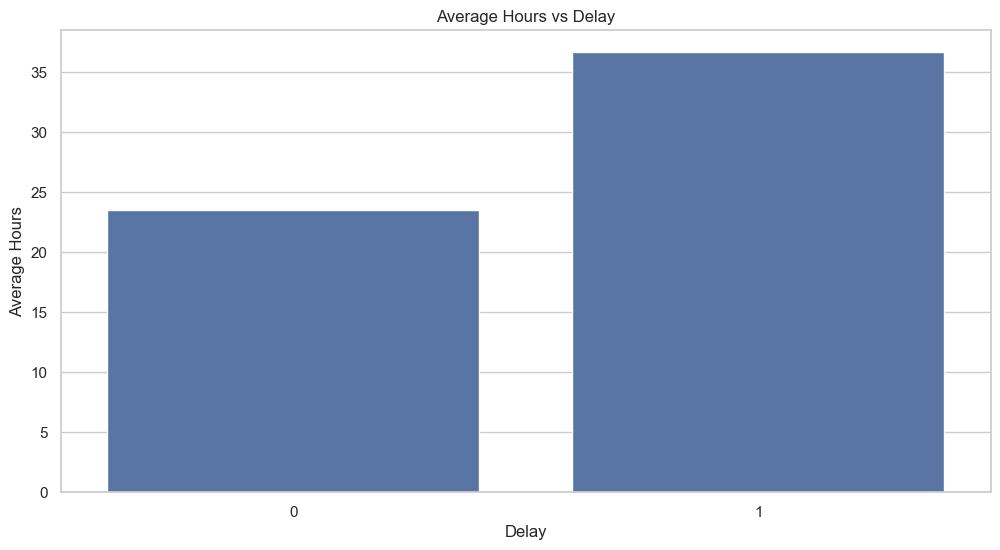

In [96]:
df = pd.DataFrame(merged_df_rw_tr_ts_t_r)

# Set the aesthetics for seaborn
sns.set(style="whitegrid")

# Bar plot for average_hours vs delay
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='delay', y='average_hours', estimator='mean', ci=None)
plt.title('Average Hours vs Delay')
plt.xlabel('Delay')
plt.ylabel('Average Hours')
plt.xticks(rotation=0)
plt.show()

2024-09-24 15:13:29,577 WARNING: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


2024-09-24 15:13:29,592 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 15:13:29,599 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


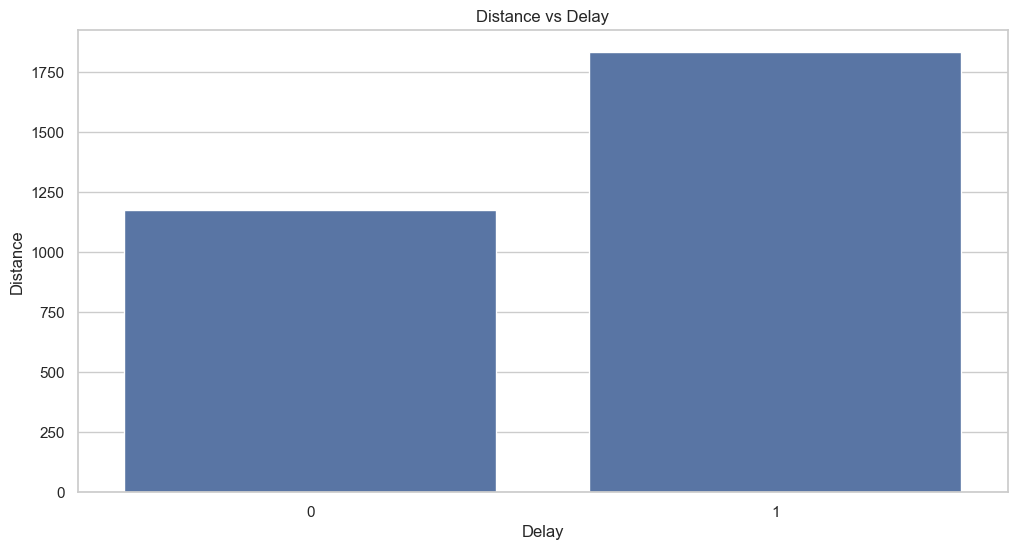

In [97]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='delay', y='distance', estimator='mean', ci=None)
plt.title('Distance vs Delay')
plt.xlabel('Delay')
plt.ylabel('Distance')
plt.xticks(rotation=0)
plt.show()

2024-09-24 15:14:25,596 WARNING: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




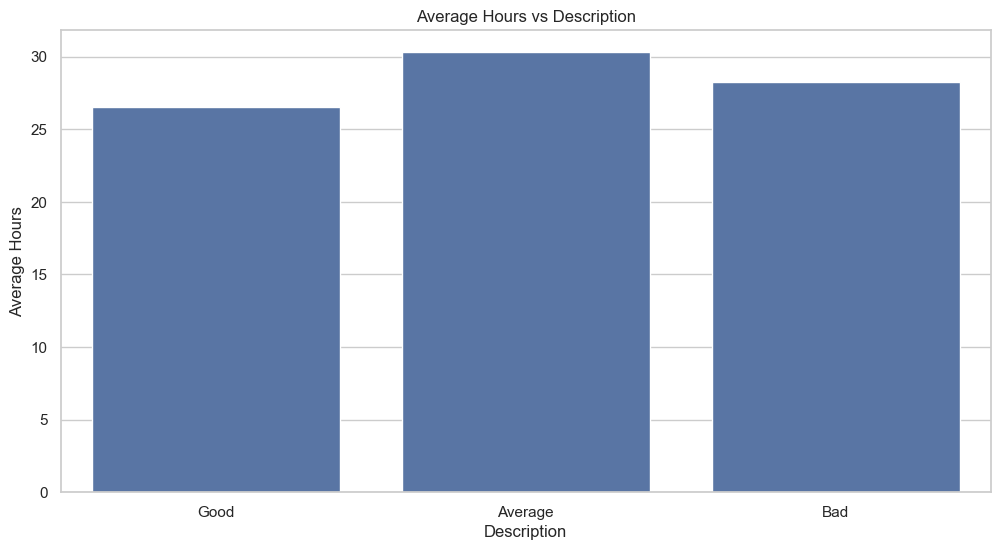

In [100]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='weather_category', y='average_hours',
            estimator='mean', ci=None)
plt.title('Average Hours vs Description')
plt.xlabel('Description')
plt.ylabel('Average Hours')
plt.xticks(rotation=0)
plt.show()

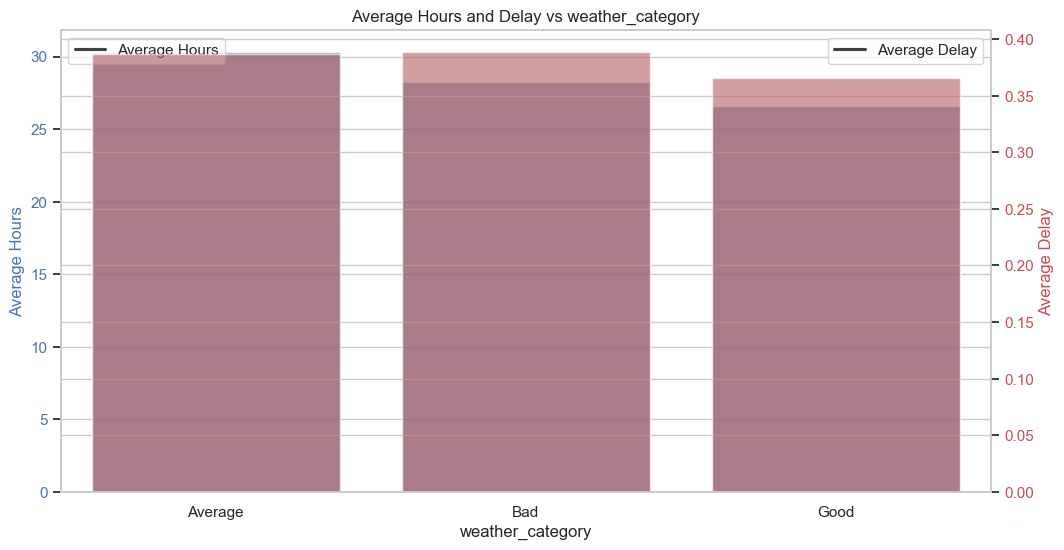

In [102]:
grouped = df.groupby('weather_category').agg(
    {'average_hours': 'mean', 'delay': 'mean'}).reset_index()

# Set the aesthetics for seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for average_hours
sns.barplot(data=grouped, x='weather_category', y='average_hours',
            ax=ax1, color='b', alpha=0.6, label='Average Hours')
ax1.set_ylabel('Average Hours', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.xticks(rotation=0)

# Create a second y-axis for the delay
ax2 = ax1.twinx()
sns.barplot(data=grouped, x='weather_category', y='delay', ax=ax2,
            color='r', alpha=0.6, label='Average Delay')
ax2.set_ylabel('Average Delay', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title('Average Hours and Delay vs weather_category')
ax1.legend(['Average Hours'], loc='upper left')
ax2.legend(['Average Delay'], loc='upper right')
plt.show()

In [103]:
df

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
1,29906375,0.262885,R-a84d2e77,2019-01-07 07:00:00,2019-01-07 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
2,32383950,1.159830,R-a84d2e77,2019-01-25 07:00:00,2019-01-25 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
3,27086559,1.159830,R-a84d2e77,2019-01-31 07:00:00,2019-01-31 12:00:00,1,0,High,Average,C-6df8beaf,C-d80a1e7d,250.02,5.00
4,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-d80a1e7d,C-6df8beaf,250.02,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,20539869,-0.992838,R-c03cec67,2019-02-06 07:00:00,2019-02-13 09:22:12,1,0,Low,Good,C-927ceb5e,C-2e349ccd,8518.61,170.37
9607,18773058,-0.992838,R-5367dcf5,2019-02-06 07:00:00,2019-02-13 11:45:00,1,0,Medium,Average,C-c92599e2,C-f5ed4c15,8637.35,172.75
9608,15735831,0.262885,R-084ab49c,2019-02-06 07:00:00,2019-02-13 12:10:48,0,0,Medium,Bad,C-c92599e2,C-34ae77b0,8658.94,173.18
9609,15483314,-0.813449,R-0de7ba0d,2019-02-06 07:00:00,2019-02-13 18:52:48,1,0,Low,Average,C-a9f2c329,C-34ae77b0,8994.17,179.88


In [104]:
df = df.drop_duplicates()
df

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
1,29906375,0.262885,R-a84d2e77,2019-01-07 07:00:00,2019-01-07 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
2,32383950,1.159830,R-a84d2e77,2019-01-25 07:00:00,2019-01-25 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,250.02,5.00
3,27086559,1.159830,R-a84d2e77,2019-01-31 07:00:00,2019-01-31 12:00:00,1,0,High,Average,C-6df8beaf,C-d80a1e7d,250.02,5.00
4,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-d80a1e7d,C-6df8beaf,250.02,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,20539869,-0.992838,R-c03cec67,2019-02-06 07:00:00,2019-02-13 09:22:12,1,0,Low,Good,C-927ceb5e,C-2e349ccd,8518.61,170.37
9607,18773058,-0.992838,R-5367dcf5,2019-02-06 07:00:00,2019-02-13 11:45:00,1,0,Medium,Average,C-c92599e2,C-f5ed4c15,8637.35,172.75
9608,15735831,0.262885,R-084ab49c,2019-02-06 07:00:00,2019-02-13 12:10:48,0,0,Medium,Bad,C-c92599e2,C-34ae77b0,8658.94,173.18
9609,15483314,-0.813449,R-0de7ba0d,2019-02-06 07:00:00,2019-02-13 18:52:48,1,0,Low,Average,C-a9f2c329,C-34ae77b0,8994.17,179.88


In [105]:
scaler_routes = StandardScaler()
df[['distance', 'average_hours']] = scaler_routes.fit_transform(
    df[['distance', 'average_hours']])

In [106]:
df

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541
1,29906375,0.262885,R-a84d2e77,2019-01-07 07:00:00,2019-01-07 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541
2,32383950,1.159830,R-a84d2e77,2019-01-25 07:00:00,2019-01-25 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541
3,27086559,1.159830,R-a84d2e77,2019-01-31 07:00:00,2019-01-31 12:00:00,1,0,High,Average,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541
4,31120899,-0.992838,R-a8541811,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-d80a1e7d,C-6df8beaf,-0.661528,-0.661541
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,20539869,-0.992838,R-c03cec67,2019-02-06 07:00:00,2019-02-13 09:22:12,1,0,Low,Good,C-927ceb5e,C-2e349ccd,3.999056,3.998997
9607,18773058,-0.992838,R-5367dcf5,2019-02-06 07:00:00,2019-02-13 11:45:00,1,0,Medium,Average,C-c92599e2,C-f5ed4c15,4.065983,4.066072
9608,15735831,0.262885,R-084ab49c,2019-02-06 07:00:00,2019-02-13 12:10:48,0,0,Medium,Bad,C-c92599e2,C-34ae77b0,4.078153,4.078190
9609,15483314,-0.813449,R-0de7ba0d,2019-02-06 07:00:00,2019-02-13 18:52:48,1,0,Low,Average,C-a9f2c329,C-34ae77b0,4.267105,4.267013


df_drivers Analysis


In [107]:
df_drivers

,driver_id,name,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,41cacbc8-c,Brandon Osborn,46,5.0,proactive,2,91138034,63.57
1,e5987499-d,Robert West,49,16.0,proactive,4,24681381,58.09
2,1a542e4f-2,Matthew Davis,49,9.0,proactive,8,15165874,59.01
3,65608209-0,Jose Taylor,49,10.0,conservative,2,54036321,40.13
4,9ca620ed-f,Sean Hester MD,47,9.0,proactive,3,26079111,59.30
...,...,...,...,...,...,...,...,...
1278,42aa7479-5,Jerry Powers,41,7.0,conservative,2,61984883,56.94
1279,79ab8f7a-c,Daniel Clark,46,13.0,conservative,4,83616092,41.22
1280,1ab17a1f-1,Joshua Johnson,45,2.0,proactive,2,23236058,57.65
1281,c1410f13-8,Charles Holmes,55,20.0,proactive,6,29596705,58.58


In [108]:
merged_df1 = pd.merge(df, df_drivers, left_on='truck_id',
                      right_on='vehicle_no', how='inner')

# Display the merged DataFrame
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,...,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,...,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,...,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,...,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,...,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,...,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,...,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,55417825,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,...,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,89462911,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,...,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,32789303,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,...,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,12036922,62.53


In [109]:
merged_df1.isnull().sum()

truck_id                0
load_capacity_pounds    0
route_id                0
departure_date          0
estimated_arrival       0
delay                   0
accident                0
traffic_class           0
weather_category        0
origin_id               0
destination_id          0
distance                0
average_hours           0
driver_id               0
name                    0
age                     0
experience              0
driving_style           0
ratings                 0
vehicle_no              0
average_speed_mph       0
dtype: int64

In [110]:
merged_df1 = merged_df1.drop_duplicates()

In [111]:
mode_value = merged_df1['load_capacity_pounds'].mode()[0]
merged_df1['load_capacity_pounds'] = merged_df1['load_capacity_pounds'].fillna(
    mode_value)
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,...,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,...,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,...,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,...,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,...,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,...,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,...,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,55417825,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,...,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,89462911,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,...,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,32789303,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,...,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,12036922,62.53


In [112]:
merged_df1.isnull().sum()

truck_id                0
load_capacity_pounds    0
route_id                0
departure_date          0
estimated_arrival       0
delay                   0
accident                0
traffic_class           0
weather_category        0
origin_id               0
destination_id          0
distance                0
average_hours           0
driver_id               0
name                    0
age                     0
experience              0
driving_style           0
ratings                 0
vehicle_no              0
average_speed_mph       0
dtype: int64

In [113]:
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,...,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,...,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,...,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,...,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,...,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,...,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,12814755,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,...,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,55417825,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,...,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,89462911,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,...,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,32789303,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,...,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,12036922,62.53


In [114]:
merged_df1 = merged_df1.drop(columns=['vehicle_no'])
# merged_df1 = merged_df1.drop(columns=['event_date','index'])//////
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,62.53


In [115]:
# merged_df1 = merged_df1.drop(columns=['event_date','index'])
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,62.53


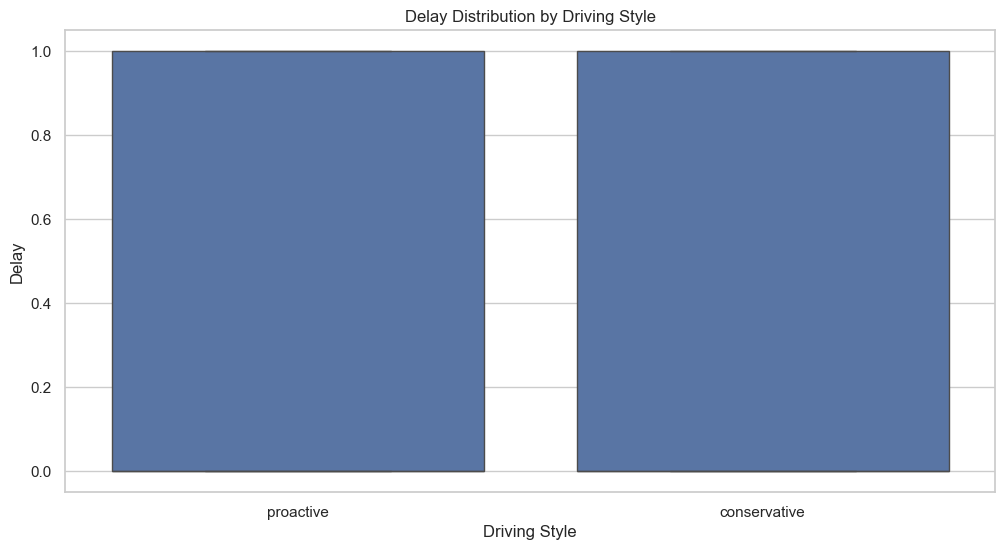

In [116]:
sns.set(style="whitegrid")

# 1. Box Plot: Delay vs Driving Style
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df1, x='driving_style', y='delay')
plt.title('Delay Distribution by Driving Style')
plt.xlabel('Driving Style')
plt.ylabel('Delay')
plt.show()

2024-09-24 15:19:54,104 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-24 15:19:54,112 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


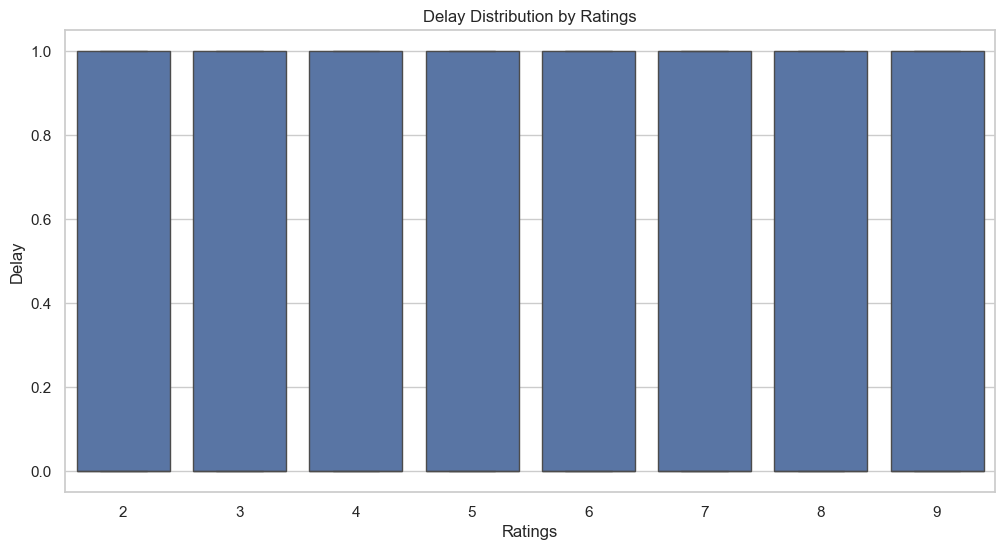

In [117]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df1, x='ratings', y='delay')
plt.title('Delay Distribution by Ratings')
plt.xlabel('Ratings')
plt.ylabel('Delay')
plt.show()

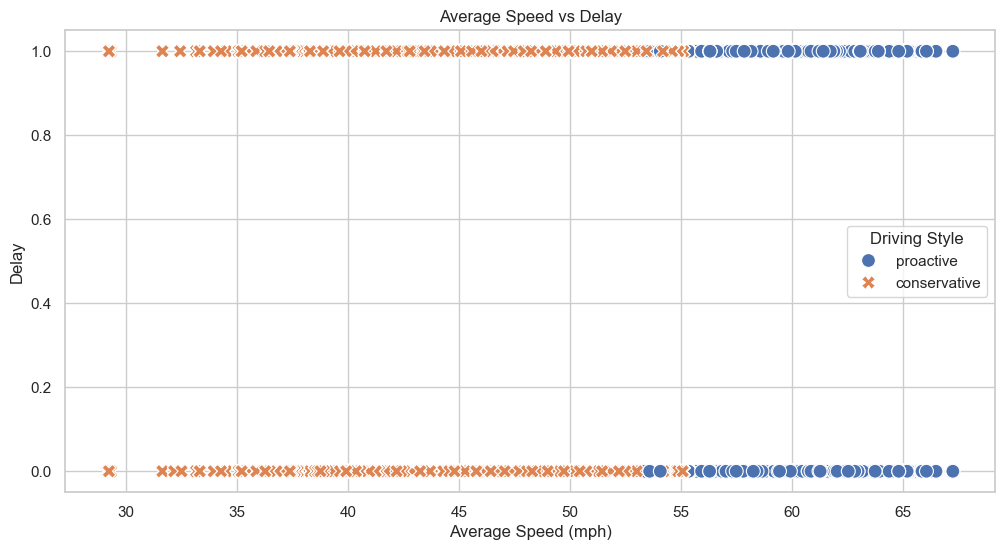

In [118]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df1, x='average_speed_mph', y='delay',
                hue='driving_style', style='driving_style', s=100)
plt.title('Average Speed vs Delay')
plt.xlabel('Average Speed (mph)')
plt.ylabel('Delay')
plt.legend(title='Driving Style')
plt.show()

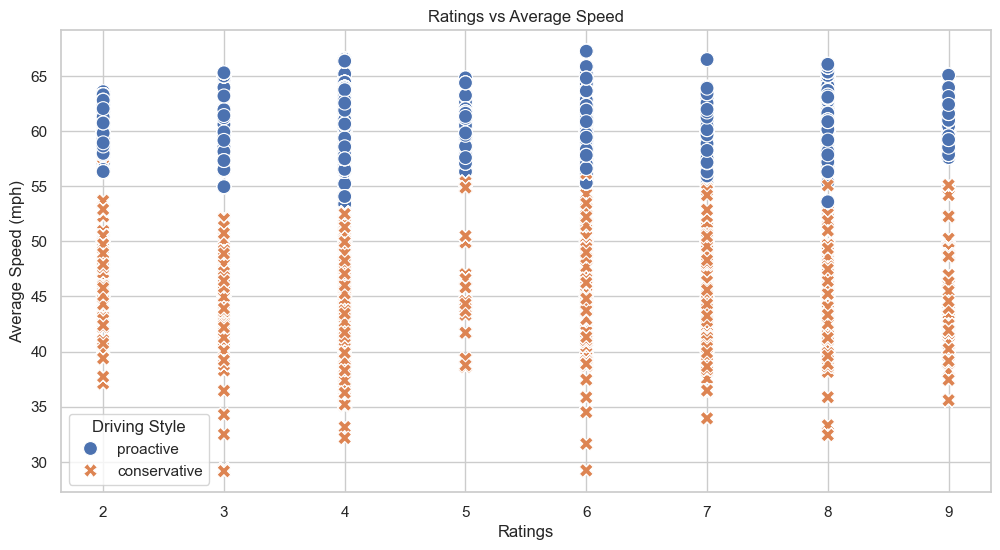

In [119]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df1, x='ratings', y='average_speed_mph',
                hue='driving_style', style='driving_style', s=100)
plt.title('Ratings vs Average Speed')
plt.xlabel('Ratings')
plt.ylabel('Average Speed (mph)')
plt.legend(title='Driving Style')
plt.show()

we do not need 2 columns since avg_spped is distributed as
if avg_speed > 55 - > provocative
else conservative


Even conservative drivers have delays in equal proportions as provocative drivers , we can actually drop and doesnt need the drivers table since delays are mostly caused by traffic, weather condition and all So we do not need columsn from the # Drivers table


In [120]:
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours,driver_id,name,age,experience,driving_style,ratings,average_speed_mph
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073,-0.292069,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454,-0.228376,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853,-0.219922,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622,-0.544584,3156d655-8,Joshua Perry,43,20.0,proactive,6,60.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763,4.696796,4280684e-5,Andrew Davidson,55,18.0,proactive,8,63.07
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212,4.782189,5f3b56db-1,Gary Quinn,49,1.0,proactive,8,59.18
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283,4.783316,5573a5ed-c,Scott Young,48,1.0,conservative,4,47.05
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294,4.822208,49d22efd-3,Christopher Maddox,51,23.0,proactive,4,62.53


In [121]:
merged_df1 = merged_df1.drop(columns=[
                             'driver_id', 'name', 'age', 'experience', 'driving_style', 'ratings', 'average_speed_mph'])

In [122]:
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance,average_hours
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528,-0.661541
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073,-0.292069
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454,-0.228376
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853,-0.219922
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622,-0.544584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763,4.696796
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212,4.782189
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283,4.783316
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294,4.822208


since the distance and avg_hours are normalized to same values i'm dropping avg_hours columns


In [123]:
merged_df1 = merged_df1.drop(columns=['average_hours'])
merged_df1

,truck_id,load_capacity_pounds,route_id,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,R-a84d2e77,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,R-4022d583,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,R-8b132770,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,R-81806ca8,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,R-a78a5e10,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,R-92744e22,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,R-dbd004d3,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,R-60cc6899,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,R-7d98b982,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294


since i have the origin city and destination city and have the weather conditions,traffic details in respective dates i dont need the route_id


In [124]:
merged_df1 = merged_df1.drop(columns='route_id')
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294


In [125]:
merged_df1 = merged_df1.drop_duplicates()

In [126]:
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294


In [127]:
df_city_weather

,city_id,temp,wind_speed,description,humidity,pressure,datetime
0,C-927ceb5e,27,2,Clear,63,1019,2019-01-02 23:00:00+00:00
1,C-731988ba,75,5,Sunny,49,1012,2019-02-09 11:00:00+00:00
2,C-b5ff31cd,16,5,Sunny,50,1033,2019-01-13 06:00:00+00:00
3,C-d9e9d934,39,6,Sunny,54,1037,2019-02-10 11:00:00+00:00
4,C-fc66f0ab,30,9,Blowing snow,89,1004,2019-02-12 12:00:00+00:00
...,...,...,...,...,...,...,...
51829,C-b25a09de,19,7,Patchy snow possible,78,1019,2019-01-27 19:00:00+00:00
51830,C-451776b7,57,7,Cloudy,81,1014,2019-02-01 16:00:00+00:00
51831,C-419cd14c,57,9,Sunny,66,1021,2019-01-01 11:00:00+00:00
51832,C-9bbf5d8a,39,4,Partly cloudy,78,1014,2019-01-29 02:00:00+00:00


I'm not merging city_weather because i have weather details for the concerned routes and the merged_df1 is my final data set for training


In [128]:
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294


In [129]:
merged_df1.isnull().sum()

truck_id                0
load_capacity_pounds    0
departure_date          0
estimated_arrival       0
delay                   0
accident                0
traffic_class           0
weather_category        0
origin_id               0
destination_id          0
distance                0
dtype: int64

In [130]:
merged_df1 = merged_df1.drop_duplicates()
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,High,Good,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,High,Average,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,Medium,Good,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,High,Good,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,Medium,Average,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,Medium,Good,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,Medium,Average,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,Medium,Good,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,Medium,Average,C-34ae77b0,C-b5ff31cd,4.822294


I beleive i have my final dataset and now i will start encoding my columns

d

In [136]:
unique_trucks = merged_df1['truck_id'].unique()
unique_trucks

array([12814755, 29906375, 32383950, ..., 32789303, 12036922, 20539869])

In [137]:
unique_trucks.shape

(1137,)

In [138]:
le_weather_category = LabelEncoder()
merged_df1['weather_category'] = le_weather_category.fit_transform(merged_df1['weather_category'])
le_traffic_class = LabelEncoder()
merged_df1['traffic_class'] = le_weather_category.fit_transform(merged_df1['traffic_class'])
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,accident,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,0,2,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,0,0,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,0,2,2,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,0,2,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,0,2,0,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,0,2,2,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,0,2,0,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,0,2,2,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,0,2,0,C-34ae77b0,C-b5ff31cd,4.822294


In [139]:
numerical_columns = ['load_capacity_pounds', 'delay',
                     'traffic_class', 'weather_category', 'distance']

# Calculate the correlation matrix
correlation_matrix = merged_df1[numerical_columns].corr()

# Display the correlation matrix
print(correlation_matrix)

                      load_capacity_pounds     delay  traffic_class  \
load_capacity_pounds              1.000000 -0.005479       0.004108   
delay                            -0.005479  1.000000       0.161389   
traffic_class                     0.004108  0.161389       1.000000   
weather_category                 -0.012861 -0.020636      -0.040914   
distance                          0.018745  0.179420       0.405739   

                      weather_category  distance  
load_capacity_pounds         -0.012861  0.018745  
delay                        -0.020636  0.179420  
traffic_class                -0.040914  0.405739  
weather_category              1.000000 -0.051699  
distance                     -0.051699  1.000000  


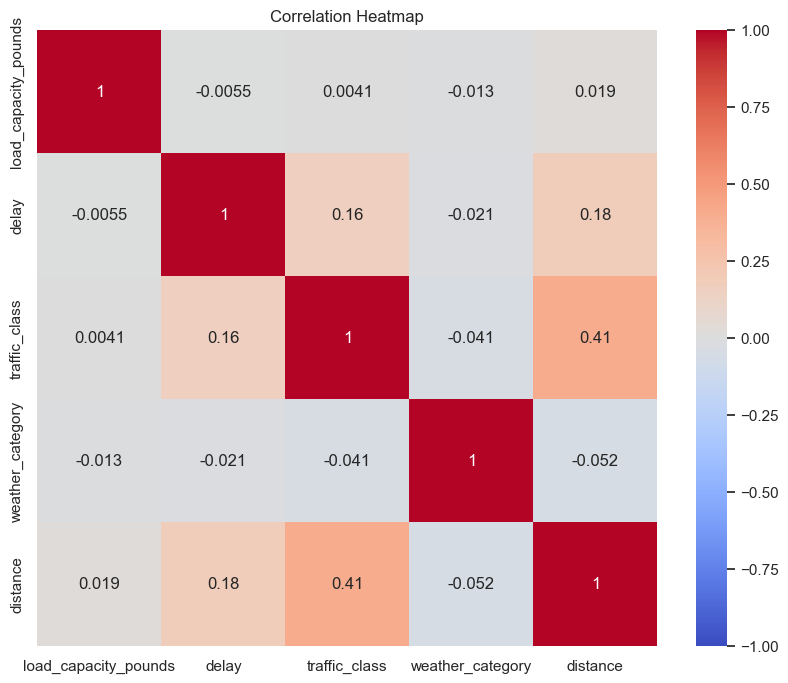

In [140]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [141]:
merged_df1 = merged_df1.drop(columns='accident')
merged_df1

,truck_id,load_capacity_pounds,departure_date,estimated_arrival,delay,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,1.159830,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,2,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,1.159830,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,0,C-84f378bb,C-639c5e36,-0.292073
2,12814755,1.159830,2019-01-07 07:00:00,2019-01-08 03:22:12,1,2,2,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,1.159830,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,2,C-639c5e36,C-56b68559,-0.219853
4,12814755,1.159830,2019-02-03 07:00:00,2019-02-03 16:09:00,0,2,0,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...,...
9483,55417825,1.159830,2019-01-19 07:00:00,2019-01-27 10:07:48,1,2,2,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,-0.813449,2019-01-19 07:00:00,2019-01-27 13:09:36,1,2,0,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,1.159830,2019-01-19 07:00:00,2019-01-27 13:12:00,0,2,2,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2.056775,2019-01-19 07:00:00,2019-01-27 14:34:47,0,2,0,C-34ae77b0,C-b5ff31cd,4.822294


In [142]:
merged_df1 = merged_df1.drop(columns=['load_capacity_pounds'])
merged_df1

,truck_id,departure_date,estimated_arrival,delay,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,2,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,0,C-84f378bb,C-639c5e36,-0.292073
2,12814755,2019-01-07 07:00:00,2019-01-08 03:22:12,1,2,2,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,2,C-639c5e36,C-56b68559,-0.219853
4,12814755,2019-02-03 07:00:00,2019-02-03 16:09:00,0,2,0,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...
9483,55417825,2019-01-19 07:00:00,2019-01-27 10:07:48,1,2,2,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,2019-01-19 07:00:00,2019-01-27 13:09:36,1,2,0,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,2019-01-19 07:00:00,2019-01-27 13:12:00,0,2,2,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2019-01-19 07:00:00,2019-01-27 14:34:47,0,2,0,C-34ae77b0,C-b5ff31cd,4.822294


In [143]:
merged_df1 = merged_df1.drop_duplicates()
merged_df1

,truck_id,departure_date,estimated_arrival,delay,traffic_class,weather_category,origin_id,destination_id,distance
0,12814755,2019-01-01 07:00:00,2019-01-01 12:00:00,0,0,2,C-6df8beaf,C-d80a1e7d,-0.661528
1,12814755,2019-02-12 07:00:00,2019-02-13 01:06:36,1,0,0,C-84f378bb,C-639c5e36,-0.292073
2,12814755,2019-01-07 07:00:00,2019-01-08 03:22:12,1,2,2,C-a9f2c329,C-40a81eb1,-0.228454
3,12814755,2019-01-13 07:00:00,2019-01-14 03:40:12,1,0,2,C-639c5e36,C-56b68559,-0.219853
4,12814755,2019-02-03 07:00:00,2019-02-03 16:09:00,0,2,0,C-90e30162,C-841ebdcb,-0.544622
...,...,...,...,...,...,...,...,...,...
9483,55417825,2019-01-19 07:00:00,2019-01-27 10:07:48,1,2,2,C-34ae77b0,C-d9e9d934,4.696763
9484,89462911,2019-01-19 07:00:00,2019-01-27 13:09:36,1,2,0,C-2e349ccd,C-73ae5412,4.782212
9485,32789303,2019-01-19 07:00:00,2019-01-27 13:12:00,0,2,2,C-2e349ccd,C-451776b7,4.783283
9486,12036922,2019-01-19 07:00:00,2019-01-27 14:34:47,0,2,0,C-34ae77b0,C-b5ff31cd,4.822294
